#### 1. 📦 Kütüphanelerin İçe Aktarılması ve Ortam Kurulumu

Bu bölümde, notebook boyunca kullanacağımız temel Python kütüphanelerini içe aktarıyor ve çalışma ortamını daha düzenli/okunabilir hale getirecek başlangıç ayarlarını yapıyoruz.

- `pandas` ve `numpy`: Veri işleme, tablo manipülasyonu ve sayısal işlemler için kullanılır.
- `seaborn` ve `matplotlib.pyplot`: Veri görselleştirme ve grafik üretimi için kullanılır.
- `sys` ve `Path` (`pathlib`): Proje dizinini (root) Python path’ine ekleyerek proje içi modüllere erişebilmek için kullanılır.
- `math`, `json`, `joblib`: Matematiksel yardımcı fonksiyonlar, JSON işlemleri ve model/nesne kaydetme-yükleme işlemleri için hazır tutulur.
- `warnings.filterwarnings('ignore')`: Uyarı mesajlarını bastırarak notebook çıktısını daha temiz hale getirir (isteğe bağlı).
- `pd.set_option("display.max_columns", None)`: DataFrame çıktısında tüm sütunların görünmesini sağlar.
- `sns.set_theme(...)` ve `plt.rcParams["figure.figsize"]`: Grafiklerin tema/palet ve varsayılan boyut ayarlarını standartlaştırır.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import math
from pathlib import Path
import json
import joblib
import warnings
# etl.ipynb: .../rfs/notebooks/etl.ipynb
# proje kökü: .../rfs
PROJECT_ROOT = Path.cwd().parents[0]
sys.path.insert(0, str(PROJECT_ROOT))

#Uyarıları devre dışı bırakmak istersen açabilirsin:

warnings.filterwarnings('ignore')

# Tüm sütunları göster
pd.set_option("display.max_columns", None)

# Grafik stilini ayarlayalım (isteğe bağlı)
sns.set_theme(style="whitegrid", palette="crest")
palette = sns.color_palette("crest", as_cmap=True)
plt.rcParams["figure.figsize"] = (10, 6)

#### 2. 📥 Veri Setinin Yüklenmesi ve Gereksiz Sütunların Kaldırılması

Bu adımda, ETL sürecinden üretilen işlenmiş veri dosyası (`laptop_data_processed.csv`) okunur ve modelleme açısından doğrudan katkısı olmayan veya tekrar/metadata niteliğindeki sütunlar veri setinden çıkarılır.

- `pd.read_csv(...)` ile veri seti `df` içine alınır.
- `drop_cols` listesi, kaldırılmak istenen sütunları tanımlar (ör. başlık, detaylı model bilgileri, scraping meta alanları vb.).
- `df.drop(...)` işleminde, **sadece gerçekten mevcut olan** sütunlar silinir (`if c in df.columns`) — böylece hata riski azaltılır.
- `df.sample(5)` ile veri setinden rastgele 5 satır görüntülenerek hızlı bir kontrol yapılır.

In [2]:

path = "../data/external/laptop_data_processed.csv"
df = pd.read_csv(path)

drop_cols = [
    "title",
    "cpu_model",
    "cpu_cores",
    "hdd_gb",
    "scraped_at",
    "url",
    "platform",
    "source_file",
]
df = df.drop(columns=[c for c in drop_cols if c in df.columns])

df.sample(5)

,brand,intended_use,color,weight,cpu_family,cpu_generation,cpu_max_ghz,ram_gb,ram_type,gpu_model,gpu_type,gpu_vram_gb,gpu_vram_type,ssd_gb,screen_size_inch,resolution,display_standard,refresh_rate_hz,panel_type,operating_system,price_try
2891,monster,oyun,siyah,2 - 4 kg,intel core ultra 9,2.0,5.0,32.0,ddr5,nvidia rtx 5080,integrated,16.0,gddr7,1024.0,18.0,2560x1600,qhd_plus,240.0,ips,windows home,220999.00
487,dell,ofis-is,siyah,1 - 2 kg,intel core i5,13.0,4.6,16.0,ddr4,intel integrated,integrated,0.0,shared,1024.0,15.6,1920x1080,fhd,120.0,wva,freedos,28754.50
161,hp,NaN,siyah,2 - 4 kg,amd ryzen 9,NaN,5.2,16.0,ddr5,nvidia rtx 4060,dedicated_high_end,16.0,gddr6,512.0,15.6,1920x1080,NaN,NaN,ips,freedos,46976.55
1670,lenovo,ofis-is,gri,2 kg ve altı,intel core i5,12.0,4.4,8.0,ddr5,intel integrated,integrated,0.0,NaN,512.0,16.0,1920x1080,hd,NaN,tn,windows home,23399.00
559,dell,ofis-is,gri,1 - 2 kg,intel core i7,13.0,5.0,32.0,ddr4,intel integrated,integrated,0.0,shared,1024.0,15.6,1920x1080,fhd,120.0,led,windows pro,39599.00


#### 3. 🔎 İlk Veri Keşfi ve Temizleme Kontrolleri

Bu bölümde veri setinin genel yapısını hızlıca analiz ediyoruz: veri boyutu (satır/sütun), mükerrer kayıtların tespiti ve temizlenmesi, sütun tipleri ve eksik değerlerin genel görünümü gibi temel kontroller yapılır. Bu kontroller, sonraki ön işleme ve modelleme adımlarına sağlam bir zemin hazırlar.

In [3]:
# veri çerçevesinin şekli
df.shape

(3384, 21)

##### 3.1 🧹 Mükerrer Kayıtların Tespiti ve Kaldırılması

Bu adımda veri setindeki tekrarlanan (duplicate) satırlar kontrol edilir ve yalnızca ilk görünen kayıt korunarak diğer kopyalar temizlenir.

- `df.duplicated(keep=False)` ile bir satırın veri setinde tekrar edip etmediği işaretlenir (tüm kopyalar `True` olur).
- `df.drop_duplicates(keep="first")` ile her mükerrer grubun **ilk satırı bırakılıp** diğerleri kaldırılır.
- `reset_index(drop=True)` ile silme sonrası indeksler sıfırdan düzenlenir.
- Yazdırılan çıktılar sayesinde kaç satırın temizlendiği ve işlem sonrası tekrar kalıp kalmadığı kontrol edilir.

In [4]:
# Tekrarlanan satırları kontrol et ve kaldır
dup_mask = df.duplicated(keep=False)
df = df.drop_duplicates(keep="first").reset_index(drop=True)

print("Dropped duplicates:", int(dup_mask.sum() - df.duplicated(keep=False).sum()))
print("Remaining duplicated rows:", int(df.duplicated().sum()))

Dropped duplicates: 38
Remaining duplicated rows: 0


In [5]:
# Null sayilarini görelim 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3365 entries, 0 to 3364
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   brand             3364 non-null   object 
 1   intended_use      2786 non-null   object 
 2   color             3155 non-null   object 
 3   weight            3261 non-null   object 
 4   cpu_family        3307 non-null   object 
 5   cpu_generation    2828 non-null   float64
 6   cpu_max_ghz       3041 non-null   float64
 7   ram_gb            3320 non-null   float64
 8   ram_type          3239 non-null   object 
 9   gpu_model         3317 non-null   object 
 10  gpu_type          3324 non-null   object 
 11  gpu_vram_gb       3289 non-null   float64
 12  gpu_vram_type     3013 non-null   object 
 13  ssd_gb            3249 non-null   float64
 14  screen_size_inch  3340 non-null   float64
 15  resolution        3344 non-null   object 
 16  display_standard  3160 non-null   object 


In [6]:
# Shows total missing values for each column
df.isnull().sum()

brand                 1
intended_use        579
color               210
weight              104
cpu_family           58
cpu_generation      537
cpu_max_ghz         324
ram_gb               45
ram_type            126
gpu_model            48
gpu_type             41
gpu_vram_gb          76
gpu_vram_type       352
ssd_gb              116
screen_size_inch     25
resolution           21
display_standard    205
refresh_rate_hz     836
panel_type          575
operating_system     30
price_try             1
dtype: int64

##### 3.2 💰 Hedef Değişkende Eksik Değerlerin Temizlenmesi

Bu adımda, modelin tahmin etmeye çalışacağı hedef değişken olan `price_try` sütununda eksik (`NaN`) değere sahip satırlar veri setinden kaldırılır.  
Hedef değişkeni eksik olan kayıtlar, denetimli öğrenme (supervised learning) sürecinde kullanılamayacağı için doğrudan temizlenir.

- `dropna(subset=["price_try"])` yalnızca `price_try` alanı boş olan satırları siler.
- Silme öncesi ve sonrası satır sayıları karşılaştırılarak kaç satırın kaldırıldığı raporlanır.
- `reset_index(drop=True)` ile indeksler yeniden düzenlenir.

In [7]:
#Fiyat sütununda null olan satırları kaldıralım
before = len(df)

df = df.dropna(subset=["price_try"]).reset_index(drop=True)

after = len(df)
print(f"Dropped rows where price_try is null: {before - after} | {before} -> {after}")

Dropped rows where price_try is null: 1 | 3365 -> 3364


In [8]:
# Eksik değer yüzdeleri
df.isnull().sum() / df.shape[0] * 100

brand                0.000000
intended_use        17.211653
color                6.242568
weight               3.091558
cpu_family           1.724138
cpu_generation      15.963139
cpu_max_ghz          9.631391
ram_gb               1.337693
ram_type             3.745541
gpu_model            1.426873
gpu_type             1.218787
gpu_vram_gb          2.259215
gpu_vram_type       10.463734
ssd_gb               3.448276
screen_size_inch     0.743163
resolution           0.624257
display_standard     6.093936
refresh_rate_hz     24.851367
panel_type          17.092747
operating_system     0.891795
price_try            0.000000
dtype: float64

#### 4. 🧹 Veri Temizleme ve Özellik Hazırlama

Bu bölümde, modelleme ve ileri analiz adımlarına geçmeden önce veri setindeki eksik değerler sistematik bir yaklaşımla ele alınır. Sayısal ve kategorik sütunlar ayrıştırılarak her biri için uygun doldurma (imputation) stratejileri uygulanır. Böylece veri seti tutarlı, eksiksiz ve makine öğrenmesi algoritmalarının doğrudan tüketebileceği bir forma getirilir.

##### 4.1 🔍 Eksik Değerlerin Temizleme Öncesi Analizi

Bu adımda, veri setindeki her bir sütun için eksik (`NaN`) değer sayıları incelenir. Böylece hangi değişkenlerin ne ölçüde eksik veri içerdiği net biçimde görülür.

##### 4.2 🧩 Sayısal ve Kategorik Sütunların Ayrıştırılması

Bu aşamada sütunlar veri tiplerine göre iki gruba ayrılır:
- **Sayısal sütunlar (`num_cols`)**: İstatistiksel doldurma yöntemleri uygulanacak değişkenler.
- **Kategorik sütunlar (`cat_cols`)**: En sık görülen değer (mode) veya varsayılan bir ifade ile doldurulacak değişkenler.

##### 4.3 📐 Sayısal Sütunlarda Medyan ile Doldurma

Sayısal değişkenlerdeki eksik değerler, ilgili sütunun **medyan** değeri ile doldurulur.  
Medyan kullanımı, özellikle uç değerlerden (outlier) etkilenmemesi nedeniyle ortalamaya kıyasla daha sağlam bir yaklaşımdır.

##### 4.4 🏷️ Kategorik Sütunlarda Mod ile Doldurma

Kategorik değişkenlerde eksik değerler, sütunun en sık tekrar eden değeri (**mode**) ile doldurulur.
- Eğer bir sütunda hiç geçerli değer yoksa, eksik alanlar `"missing"` etiketi ile doldurulur.
- Bu yaklaşım, kategorik dağılımı mümkün olduğunca korumayı hedefler.

##### 4.5 ✅ Temizleme Sonrası Eksik Değer Kontrolü

Son adımda, uygulanan doldurma işlemlerinin ardından veri setindeki eksik değerler tekrar kontrol edilir.  
Bu kontrol, veri setinin artık eksiksiz ve modelleme aşamasına hazır olduğunu doğrulamak için yapılır.

In [9]:
# 1) Önce null sayıları
print("--- NULLS BEFORE ---")
print(df.isna().sum().sort_values(ascending=False))

# 2) Kolon tip listeleri
num_cols = df.select_dtypes(include=["number"]).columns.tolist()
cat_cols = [c for c in df.columns if c not in num_cols]

# 3) Numeric -> median
for c in num_cols:
    med = df[c].median()
    df[c] = df[c].fillna(med)

# 4) Categorical -> mode (yoksa 'missing')
for c in cat_cols:
    if df[c].dropna().empty:
        df[c] = df[c].fillna("missing")
    else:
        mode = df[c].mode(dropna=True)
        fill_val = mode.iloc[0] if len(mode) else "missing"
        df[c] = df[c].fillna(fill_val)

# 5) Sonra null sayıları
print("\n--- NULLS AFTER ---")
print(df.isna().sum().sort_values(ascending=False))

--- NULLS BEFORE ---
refresh_rate_hz     836
intended_use        579
panel_type          575
cpu_generation      537
gpu_vram_type       352
cpu_max_ghz         324
color               210
display_standard    205
ram_type            126
ssd_gb              116
weight              104
gpu_vram_gb          76
cpu_family           58
gpu_model            48
ram_gb               45
gpu_type             41
operating_system     30
screen_size_inch     25
resolution           21
brand                 0
price_try             0
dtype: int64

--- NULLS AFTER ---
brand               0
gpu_vram_gb         0
operating_system    0
panel_type          0
refresh_rate_hz     0
display_standard    0
resolution          0
screen_size_inch    0
ssd_gb              0
gpu_vram_type       0
gpu_type            0
intended_use        0
gpu_model           0
ram_type            0
ram_gb              0
cpu_max_ghz         0
cpu_generation      0
cpu_family          0
weight              0
color               0
p

In [10]:
# Final check - tüm sütunlardaki null sayıları
df.isnull().sum()

brand               0
intended_use        0
color               0
weight              0
cpu_family          0
cpu_generation      0
cpu_max_ghz         0
ram_gb              0
ram_type            0
gpu_model           0
gpu_type            0
gpu_vram_gb         0
gpu_vram_type       0
ssd_gb              0
screen_size_inch    0
resolution          0
display_standard    0
refresh_rate_hz     0
panel_type          0
operating_system    0
price_try           0
dtype: int64

##### 4.6 📊 Kategorik (Object) Sütunlarda Değer Dağılımlarının İncelenmesi

Bu adımda, veri setindeki **kategorik (object tipindeki)** sütunlar için değer dağılımları incelenir. Her bir kategorinin kaç kez tekrar ettiği görüntülenerek veri setinin yapısı hakkında daha detaylı bir fikir edinilir.

- `select_dtypes(include='object')` ile yalnızca kategorik sütunlar seçilir.
- `value_counts()` her bir benzersiz değerin frekansını gösterir.
- Sütunlar arası çıktının daha okunabilir olması için ayraç (`'****'`) kullanılır.
- Bu inceleme, nadir kategorilerin, dengesiz dağılımların veya anormal değerlerin tespit edilmesine yardımcı olur.

In [11]:
# Obje sütunlar için değer sayımları
for i in df.select_dtypes(include='object').columns:
     print(df[i].value_counts())
     print('****'*10)

brand
lenovo        1195
asus           650
hp             324
casper         257
dell           248
msi            218
monster        159
acer           155
game garaj      75
erazer          25
huawei          22
samsung         10
gigabyte         7
hometech         5
i-life           5
toshiba          3
tecno            2
chuwi            1
xiaomi           1
quadro           1
microsoft        1
Name: count, dtype: int64
****************************************
intended_use
ofis-is    1980
oyun       1155
ev-okul     224
tasarım       4
ev            1
Name: count, dtype: int64
****************************************
color
gri                 1663
siyah               1224
mavi                 208
gümüş                174
renkli                60
beyaz                 20
siiyah                 2
füme                   2
altın                  2
rose                   2
gr                     1
deniz kabuğu           1
metalik                1
haki                   1
s           

##### 4.7 🔢 Sayısal Sütunlarda Değer Dağılımlarının İncelenmesi

Bu adımda, veri setindeki **sayısal (numeric)** sütunlar için değer dağılımları incelenir. Her bir benzersiz sayısal değerin kaç kez tekrar ettiği analiz edilerek değişkenlerin dağılım yapısı ve yoğunlukları gözlemlenir.

- `select_dtypes(include='number')` ile yalnızca sayısal sütunlar seçilir.
- `value_counts()` kullanılarak her bir sayısal değerin frekansı hesaplanır.
- Çıktılar arasındaki ayrımı netleştirmek için ayraç (`'****'`) eklenir.
- Bu analiz; sabit (tek değerli) sütunların, aşırı tekrar eden değerlerin ve potansiyel anomali içeren değişkenlerin tespit edilmesine yardımcı olur.

In [12]:
# Numerik sütunlar için değer sayımları
for i in df.select_dtypes(include='number').columns:
     print(df[i].value_counts())
     print('****'*10)

cpu_generation
13.0    2034
12.0     553
7.0      242
14.0     172
2.0      103
5.0       59
1.0       59
8.0       48
11.0      35
4.0       17
9.0       17
10.0      12
3.0        8
6.0        5
Name: count, dtype: int64
****************************************
cpu_max_ghz
4.60    973
5.00    425
4.90    400
4.40    351
4.50    226
4.70    174
4.80    143
4.30    103
5.20     47
5.80     43
5.40     43
4.00     35
5.10     35
4.55     33
4.20     24
2.10     22
3.40     20
3.70     20
3.20     19
2.80     18
1.70     17
2.00     17
5.50     17
3.00     16
2.40     15
3.80     14
3.60     13
5.30     13
3.30     10
4.10      9
1.20      8
2.20      7
3.10      7
2.70      7
2.60      6
2.30      5
1.40      5
2.90      4
1.80      4
2.50      4
1.10      3
1.30      3
3.50      2
1.50      2
1.60      1
6.00      1
Name: count, dtype: int64
****************************************
ram_gb
16.0     1396
32.0      733
8.0       483
24.0      253
64.0      215
40.0       80
12.0       51


In [13]:
# 1) Resolution -> width/height ayıkla (boşluk/×/X toleranslı)
wh = (
    df["resolution"]
    .astype("string")
    .str.lower()
    .str.replace("×", "x", regex=False)
    .str.extract(r"(?P<w>\d{3,5})\s*x\s*(?P<h>\d{3,5})")
)

df["res_w"] = pd.to_numeric(wh["w"], errors="coerce")
df["res_h"] = pd.to_numeric(wh["h"], errors="coerce")

# 2) PPI = diagonal_pixels / diagonal_inches
inch = pd.to_numeric(df["screen_size_inch"], errors="coerce")
diag_px = np.sqrt(df["res_w"] ** 2 + df["res_h"] ** 2)

df["ppi"] = np.where((inch > 0) & diag_px.notna(), diag_px / inch, np.nan)

# 3) Kontrol
print("PPI NaN count:", int(df["ppi"].isna().sum()))
df[["screen_size_inch", "resolution", "res_w", "res_h", "ppi"]].head(10)

df = df.drop(columns=["res_w", "res_h"])

i_ppi = df.columns.get_loc("ppi")
i_prc = df.columns.get_loc("price_try")
cols = list(df.columns)
cols[i_ppi], cols[i_prc] = cols[i_prc], cols[i_ppi]
df = df[cols]

PPI NaN count: 0


#### 6. 📊 Keşifsel Veri Analizi (EDA): Sayısal Değişkenlerin Dağılımları

Bu bölümde, veri setindeki **tüm sayısal değişkenlerin dağılımları** histogramlar aracılığıyla incelenir. Amaç; değişkenlerin yoğunlaştığı aralıkları, olası çarpıklıkları (skewness), uç değerleri (outlier) ve genel veri yapısını görsel olarak analiz etmektir.


##### 6.1 📈 Sayısal Değişkenler İçin Histogram Görselleştirmesi

Bu adımda:
- `select_dtypes(include="number")` ile yalnızca sayısal sütunlar seçilir.
- Her değişken için ayrı bir histogram çizilir.
- Grafikler, okunabilirliği artırmak amacıyla **3 sütunlu bir grid yapı** içerisinde otomatik olarak yerleştirilir.
- Eksik değerler histogramlara dahil edilmez (`dropna()`).

Bu yaklaşım, tüm sayısal değişkenleri **tek bir bakışta** değerlendirmeye imkân tanır.

##### 6.1.1 🔍 Grafiklerin Genel Yorumu

Histogram çıktıları incelendiğinde şu genel gözlemler yapılabilir:

- **cpu_generation**: Değerlerin belirli nesillerde yoğunlaştığı görülmektedir. Bu durum piyasada ağırlıklı olarak güncel işlemci nesillerinin yer aldığını göstermektedir.
- **cpu_max_ghz**: Değerler büyük ölçüde 4–5 GHz aralığında toplanmıştır. Dağılım görece dar olup aşırı uç değer sayısı sınırlıdır.
- **ram_gb**: 8 GB ve 16 GB RAM konfigürasyonları baskındır. Daha yüksek RAM değerleri (64 GB ve üzeri) oldukça nadirdir ve potansiyel uç değer olarak değerlendirilebilir.
- **gpu_vram_gb**: 0–8 GB aralığında yoğunlaşma vardır. Entegre GPU’lu cihazlar (0 GB) önemli bir paya sahiptir.
- **ssd_gb**: 256 GB, 512 GB ve 1 TB değerlerinde belirgin kümelenmeler gözlemlenir. Bu durum piyasa standartlarıyla uyumludur.
- **screen_size_inch**: 15.6 inç etrafında güçlü bir yoğunlaşma vardır. Bu da dizüstü bilgisayar pazarındaki en yaygın ekran boyutunu yansıtır.
- **refresh_rate_hz**: 60 Hz, 120 Hz ve 144 Hz değerlerinde belirgin tepe noktaları bulunmaktadır. Yüksek yenileme hızları daha sınırlı bir kitleye hitap etmektedir.
- **ppi**: Değerler belirli bir aralıkta yoğunlaşmış olup, çok yüksek PPI değerleri nadirdir. Bu özellik, ekran kalitesi açısından ayırt edici bir sinyal sunmaktadır.
- **price_try**: Dağılım belirgin biçimde **sağa çarpıktır (right-skewed)**. Uygun fiyatlı modeller çoğunlukta iken, yüksek fiyatlı cihazlar uzun bir kuyruk oluşturmaktadır. Bu durum modelleme aşamasında log-dönüşüm gibi tekniklerin değerlendirilebileceğine işaret eder.

##### 6.1.2 🧠 Modelleme Açısından Çıkarımlar

- Birçok değişkende **doğal kümelenmeler** bulunması, ağaç tabanlı modeller için avantajlıdır.
- `price_try` ve bazı donanım özelliklerinde gözlenen çarpıklıklar, doğrusal modellerde ek dönüşümler gerektirebilir.
- Sayısal değişkenlerin büyük bölümü anlamlı varyans içerdiğinden, modelin açıklayıcılığını artıracak güçlü adaylardır.

Bu analizle birlikte veri setinin sayısal yapısı netleşmiş ve sonraki modelleme adımlarına geçmek için sağlam bir temel oluşturulmuştur.

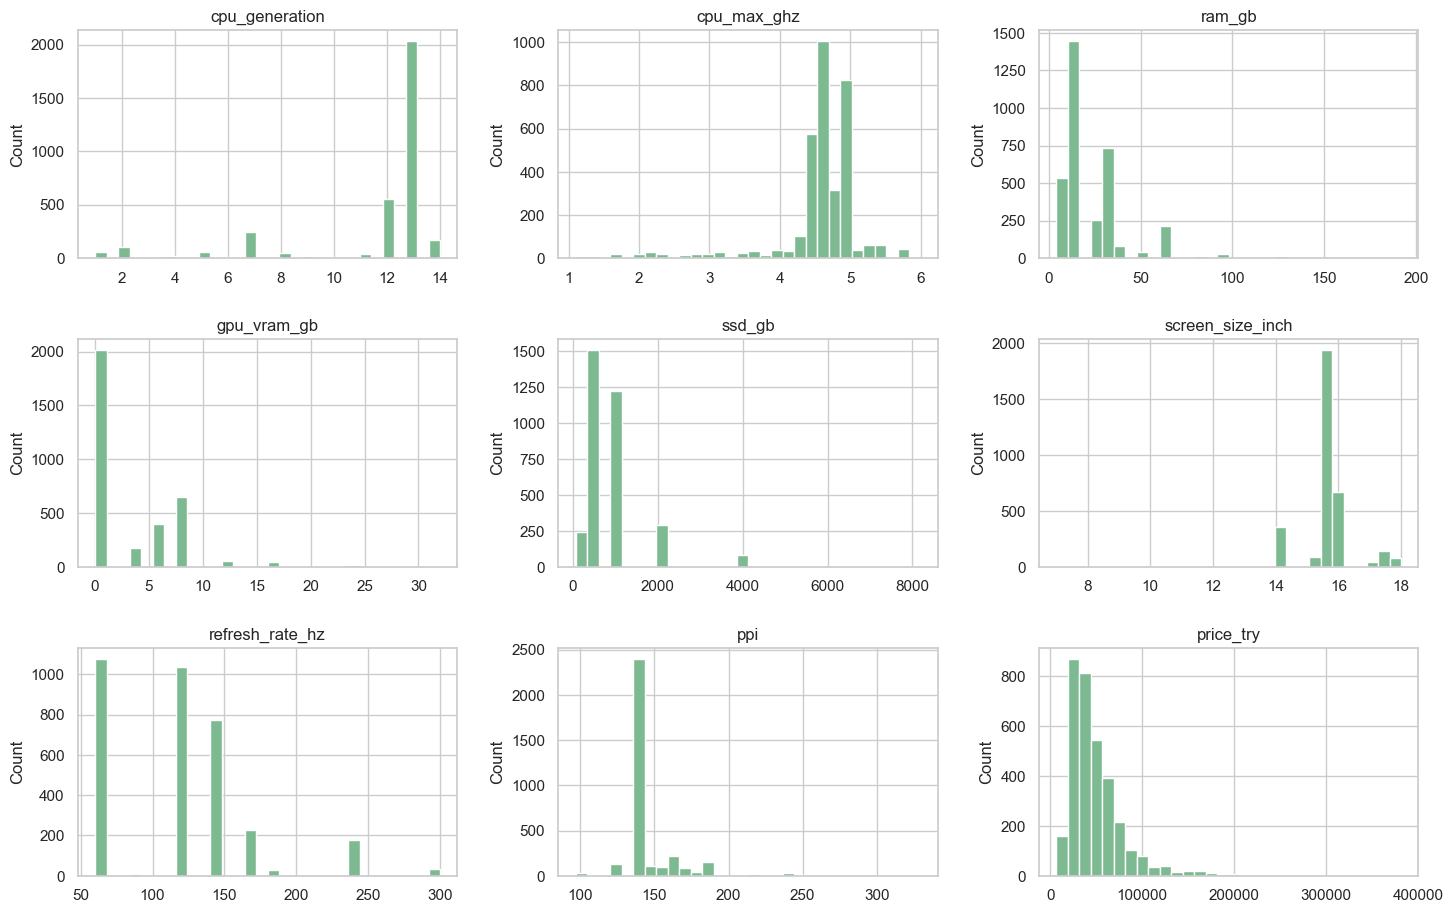

In [14]:
# Sayısal kolonlar
numeric_cols = df.select_dtypes(include="number").columns.tolist()

# Grid boyutu (1 satırda 3 grafik)
n_cols = 3
n_rows = math.ceil(len(numeric_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3.2 * n_rows))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    s = df[col].dropna()
    axes[i].hist(s, bins=30)
    axes[i].set_title(col)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Count")

# Boş subplotları kaldır
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(pad=2.0)
plt.show()

##### 6.2 🧪 Sayısal Değişkenlerde Aykırı Değer (Outlier) Analizi

Bu alt bölümde, veri setindeki **sayısal değişkenlerde bulunan aykırı değerler** kutu grafikleri (boxplot) yardımıyla incelenir. Amaç; değişkenlerin merkezi eğilimleri, yayılım aralıkları (IQR) ve uç değerlerin dağılım üzerindeki etkisini görsel olarak değerlendirmektir.

##### 6.2.1 📦 Boxplot Yaklaşımı ile Outlier Gözlemi

Bu adımda:
- `select_dtypes(include="number")` ile yalnızca sayısal sütunlar seçilir.
- Her bir sayısal değişken için ayrı bir **boxplot** çizilir.
- Grafikler, karşılaştırmayı kolaylaştırmak için **4 sütunlu bir grid** düzeninde yerleştirilir.
- Her kutu grafiği; medyan, çeyrekler arası aralık (IQR) ve potansiyel aykırı değerleri açıkça göstermektedir.

##### 6.2.2 🔍 Grafiklerin Genel Yorumu

Boxplot çıktıları incelendiğinde aşağıdaki gözlemler öne çıkmaktadır:

- **cpu_generation**: Alt nesillerde sınırlı sayıda aykırı değer bulunmaktadır. Veri büyük ölçüde güncel nesiller etrafında toplanmıştır.
- **cpu_max_ghz**: Düşük ve yüksek uçlarda birkaç aykırı değer gözlemlense de genel dağılım görece dengelidir.
- **ram_gb**: Yüksek RAM değerleri (64 GB ve üzeri) belirgin aykırı değerler olarak öne çıkmaktadır.
- **gpu_vram_gb**: Entegre GPU’lar (0 GB) yoğunluk gösterirken, 16 GB ve üzeri değerler aykırı olarak konumlanmaktadır.
- **ssd_gb**: 2 TB ve üzeri depolama kapasiteleri, ana dağılımdan belirgin biçimde ayrılmaktadır.
- **screen_size_inch**: Standart ekran boyutları (14–16 inç) dışında kalan değerler sınırlı sayıdadır.
- **refresh_rate_hz**: 240 Hz ve üzeri yenileme hızları aykırı değer niteliği taşımaktadır.
- **ppi**: Çok yüksek PPI değerleri (yüksek çözünürlüklü ve küçük ekranlı cihazlar) ana dağılımdan ayrışmaktadır.
- **price_try**: Dağılım güçlü biçimde sağa çarpıktır; üst segment fiyatlar uzun bir kuyruk oluşturarak belirgin aykırı değerler üretmektedir.

##### 6.2.3 🧠 Modelleme Açısından Değerlendirme

- Aykırı değerler **veri hatası değil**, çoğunlukla üst segment donanım konfigürasyonlarını temsil etmektedir.
- Ağaç tabanlı modeller bu tür aykırı değerlere karşı daha dayanıklıdır.
- Doğrusal modeller veya mesafe temelli algoritmalar için log-dönüşüm, winsorization veya robust scaler gibi yöntemler ilerleyen adımlarda değerlendirilebilir.

Bu analiz ile sayısal değişkenlerdeki aykırı değerlerin yapısı netleşmiş ve uygun ön işleme stratejileri için gerekli içgörüler elde edilmiştir.### Sayısal Sütunlardaki Aykırı Değerlerin Görselleştirilmesi

Bu bölümde, veri setindeki sayısal değişkenler için `boxplot` grafiklerinden yararlanılarak aykırı (outlier) değerler incelenmiştir. Her bir sayısal sütun için ayrı ayrı kutu grafiği çizilmiştir.

**Boxplot (Kutu Grafiği):**

- Ortadaki çizgi medyan değeri gösterir.
- Kutu (box) alt ve üst çeyrek değerlerini (Q1, Q3) temsil eder.
- Kutu dışındaki noktalar (uçlarda yer alanlar) genellikle aykırı değer olarak kabul edilir.

Bu analiz, özellikle regresyon gibi modellerde aykırı değerlerin etkisini azaltmak veya filtrelemek için faydalıdır. Aykırı değerler tespit edildikten sonra veri ön işleme aşamasında uygun bir şekilde ele alınabilir (örneğin silme, sınırlandırma, dönüştürme vb.).

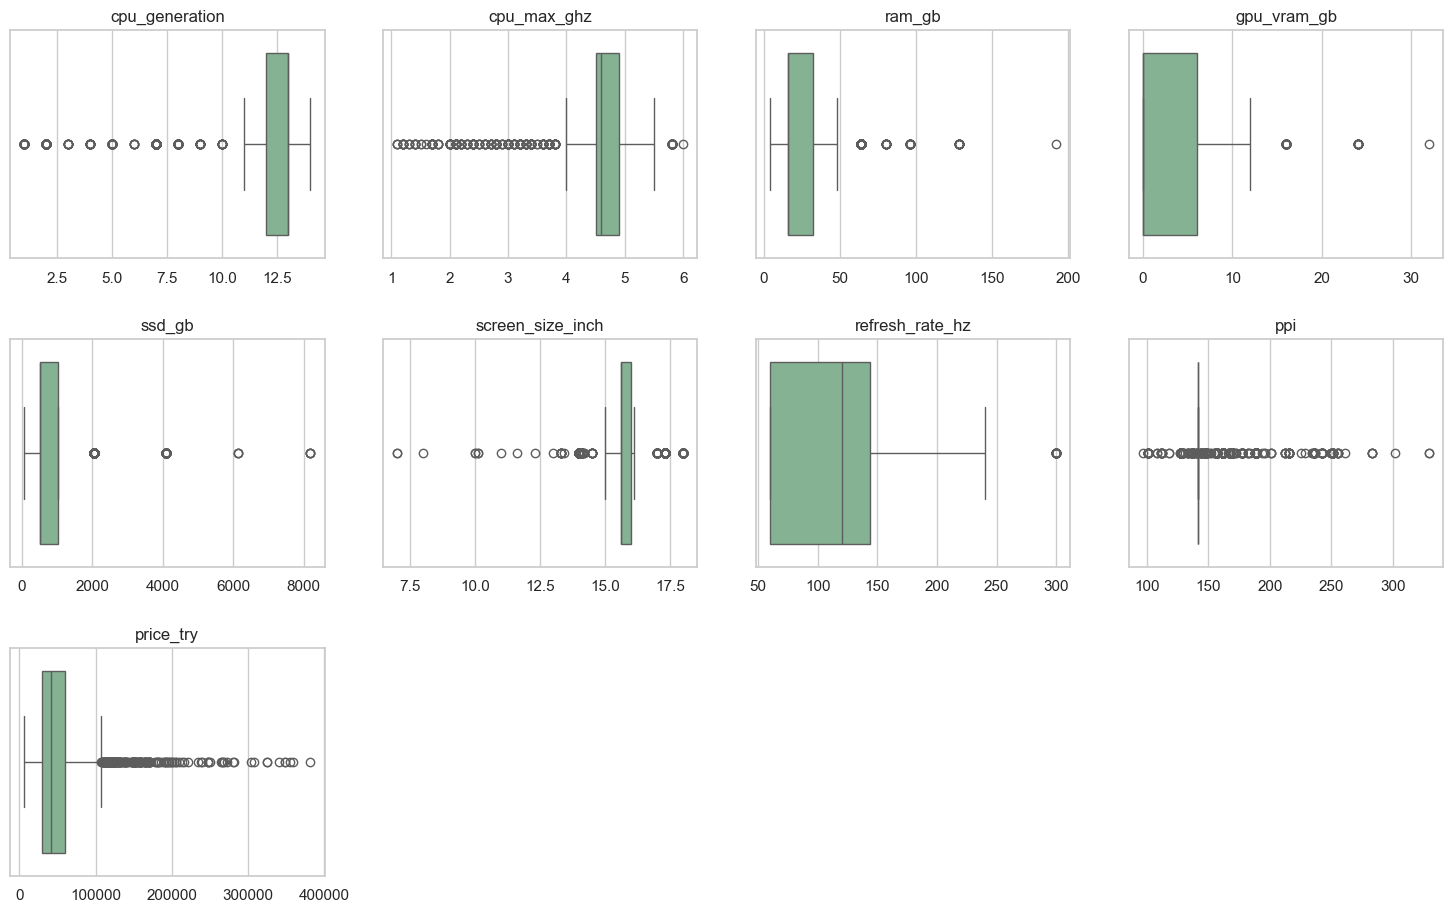

In [15]:
# Sayisal kolonlardaki aykiri degerleri gozlemleyelim
numeric_cols = df.select_dtypes(include="number").columns.tolist()

# Grid boyutu
n_cols = 4
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

# Grafik alanını oluştur
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3.2 * n_rows))
axes = axes.flatten()  # Kolay erişim için düzleştir

# Her sütun için boxplot çiz
for i, col in enumerate(numeric_cols):
    sns.boxplot(data=df, x=col, ax=axes[i])
    axes[i].set_title(f"{col}")
    axes[i].set_xlabel("")

# Boş kalan subplotları kaldır
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(pad=2.0)
plt.show()

##### 6.3 🔗 Sayısal Değişkenler ile Fiyat (price_try) Arasındaki İlişki Analizi

Bu alt bölümde, hedef değişkenimiz olan **`price_try`** ile sayısal özellikler arasındaki ilişkiyi görmek için her bir değişken için **scatter plot (dağılım grafiği)** oluşturulur. Amaç; fiyatı açıklamada güçlü olabilecek değişkenleri, olası doğrusal/ doğrusal olmayan eğilimleri ve kümelenmeleri görsel olarak tespit etmektir.

##### 6.3.1 🧩 Scatter Plot Grid Yapısının Kurulması

Bu adımda:
- Sayısal sütunlar `features` listesine alınır ve hedef değişken olan `price_try` listeden çıkarılır.
- Grafikler **2 sütunlu** bir grid düzende otomatik yerleştirilir.
- Her grafik için `sns.scatterplot()` kullanılarak `x=feature`, `y=price_try` ilişkisi çizilir.
- Noktaların rengi `price_try` değerine göre (hue) ayarlanır; böylece düşük/yüksek fiyat bölgeleri görsel olarak ayrışır.

##### 6.3.2 🔍 Grafiklerin Genel Yorumu (Ekteki Çıktıya Göre)

Ekteki scatter plot çıktıları üzerinden dikkat çeken eğilimler:

- **cpu_generation vs price_try**: İşlemci nesli yükseldikçe fiyatın genel olarak arttığı görülüyor. Ancak aynı nesil içinde geniş bir fiyat aralığı var; yani tek başına yeterli değil ama güçlü bir sinyal.
- **cpu_max_ghz vs price_try**: 4–5+ GHz bandında cihaz yoğunluğu artarken, özellikle yüksek frekanslarda üst fiyat segmentine daha sık geçiş var. Yine de dağılım yaygın, ilişki doğrusal değil.
- **ram_gb vs price_try**: RAM kapasitesi arttıkça fiyatın yukarı yönlü eğilim gösterdiği açık. 64 GB ve üzeri konfigürasyonlar genellikle üst segmentte kümeleniyor. Ancak 16–32 GB bandında ciddi fiyat farklılıkları mevcut.
- **gpu_vram_gb vs price_try**: GPU VRAM arttıkça fiyat belirgin şekilde yükseliyor. 0 GB (entegre) cihazlar genelde alt segmentte toplanırken, 8–16–24 GB gibi değerler üst segmentle daha fazla ilişkili.
- **ssd_gb vs price_try**: SSD kapasitesinde 512/1024/2048 gibi değerlerde kümelenmeler var. Kapasite yükseldikçe fiyat artma eğiliminde; fakat marka/CPU/GPU gibi diğer bileşenler etkili olduğu için saçılım geniş.
- **screen_size_inch vs price_try**: Ekran boyutu tek başına güçlü bir belirleyici değil. 15.6 civarında yoğunluk olmasına rağmen fiyatlar geniş bir aralıkta dağılmış. Büyük ekran (17–18) modeller üst segmente daha sık çıkıyor.
- **refresh_rate_hz vs price_try**: 60 Hz cihazlar daha çok alt-orta segmentte. 120/144/165/240 Hz gibi değerlerde üst segmente kayış gözleniyor; bu değişken özellikle “gaming” sınıfı cihazları ayırt etmede etkili olabilir.
- **ppi vs price_try**: PPI arttıkça (daha yüksek çözünürlük / daha iyi ekran) üst fiyatlara geçiş eğilimi var; ancak ilişki gürültülü. Yine de ekran kalitesi tarafında açıklayıcı bir katkı sağlayabilir.

##### 6.3.3 🧠 Modelleme Açısından Çıkarımlar

- **GPU VRAM**, **RAM**, **SSD kapasitesi**, **CPU nesli** gibi değişkenler fiyatla daha net ilişki gösteriyor.
- Birçok değişkende **kümelenmeler** (ör. 8/16/32 GB RAM, 256/512/1024 SSD, 60/144 Hz) var; bu, gerçek dünya ürün konfigürasyonlarının standardizasyonundan kaynaklanır.
- `price_try` dağılımı ve saçılım geniş olduğu için (özellikle üst segment) doğrusal modellere göre **ağaç tabanlı yöntemler** (RF, GBM, XGB) daha iyi performans gösterebilir.
- İlerleyen adımlarda `price_try` için **log dönüşümü** veya robust ölçekleme gibi seçenekler de değerlendirilebilir.

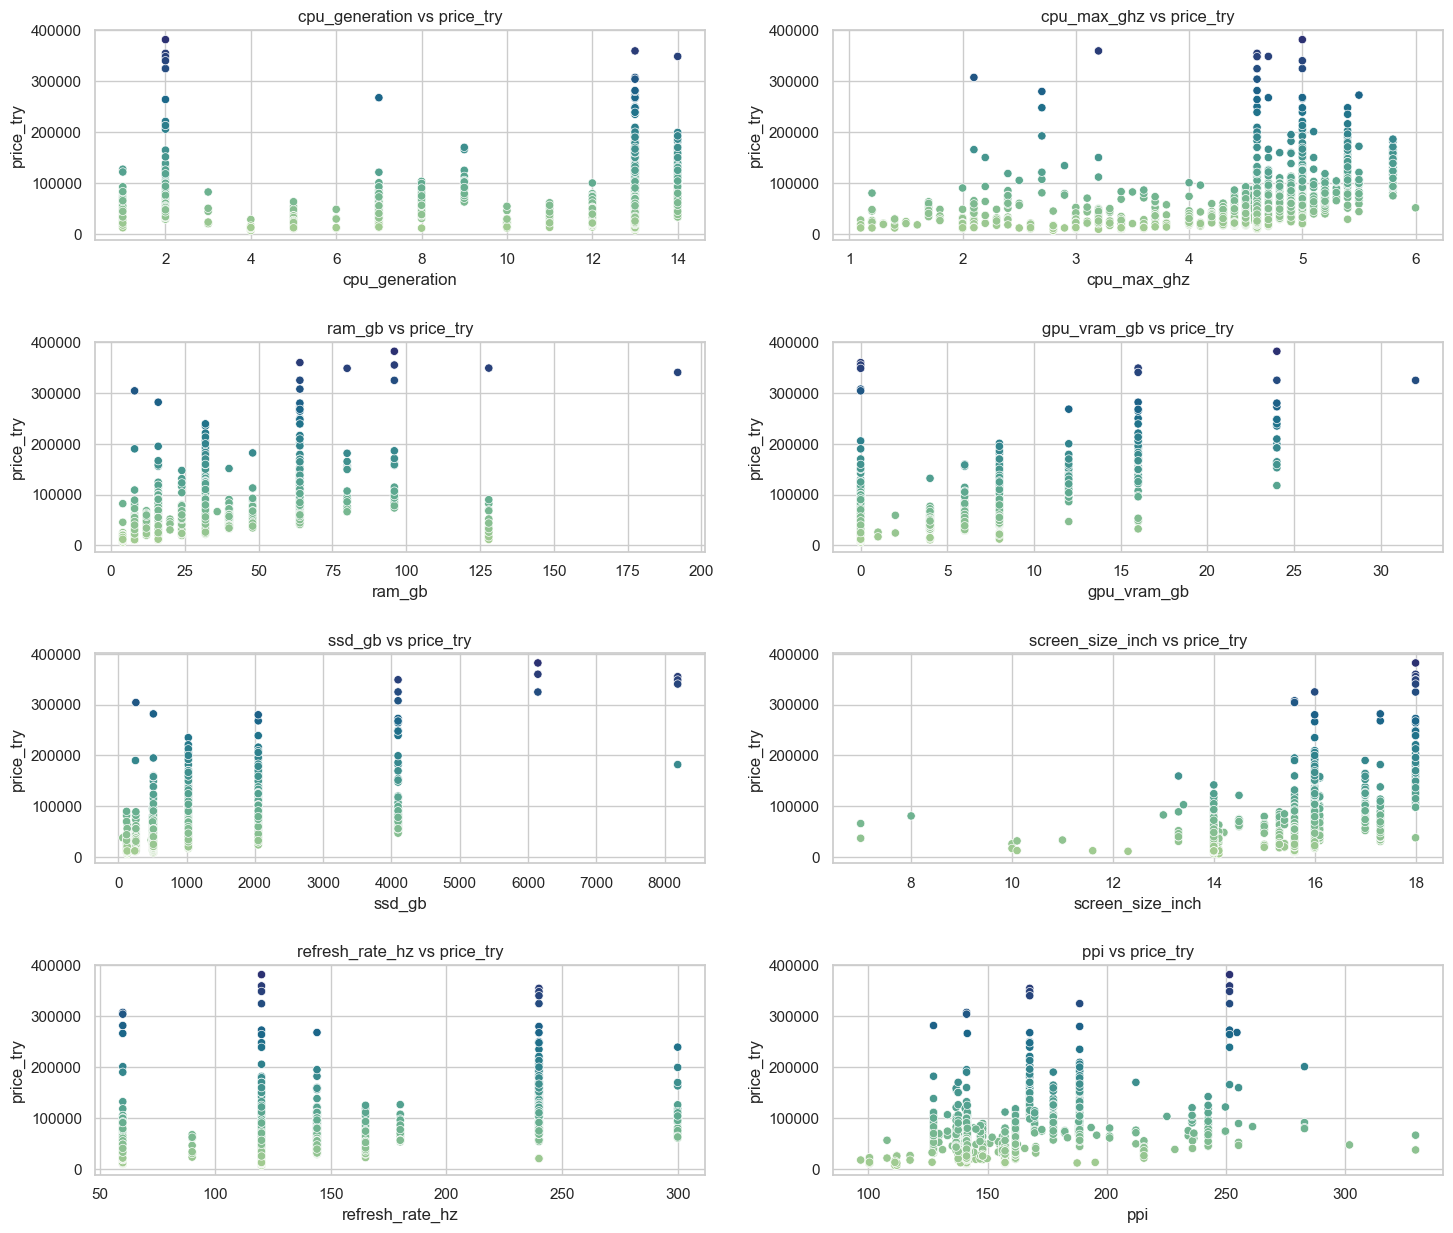

In [16]:
# numerical kolonlar ile Fiyat (TRY) arasindaki iliskiyi gozlemleyelim
# İncelenecek sayısal sütunlar
features = df.select_dtypes(include="number").columns.tolist()
features.remove("price_try")  # Hedef değişkeni çıkar

n_cols = 2
n_rows = (len(features) + n_cols - 1) // n_cols  # Satır sayısı hesaplanıyor

# Grid yapısı oluşturuluyor
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3.2 * n_rows))
axes = axes.flatten()  # Kolay indeksleme için düzleştirme

# Her scatterplot için döngü
for i, feature in enumerate(features):
    sns.scatterplot(
        data=df,
        x=feature,
        y="price_try",
        ax=axes[i],
        hue=df["price_try"],
        palette=palette,
        legend=False,
    )
    axes[i].set_title(f"{feature} vs price_try")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("price_try")

# Boş kalan subplot'lar varsa sil
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(pad=2.0)
plt.show()

##### 6.4 📉 Fiyat Dağılımı ve Log-Dönüşüm Analizi

Bu alt bölümde, hedef değişken olan **`price_try`** için hem orijinal dağılım hem de logaritmik dönüşüm sonrası dağılım incelenir. Amaç; fiyat değişkeninin çarpıklığını (skewness) analiz etmek ve modelleme açısından daha uygun bir temsil olup olmadığını değerlendirmektir.

##### 6.4.1 🔍 Orijinal Fiyat Dağılımının İncelenmesi

Orijinal `price_try` histogramı incelendiğinde:

- Dağılımın **belirgin biçimde sağa çarpık (right-skewed)** olduğu görülmektedir.
- Düşük ve orta fiyatlı ürünler yoğunluktayken, yüksek fiyatlı ürünler uzun bir kuyruk oluşturmaktadır.
- Üst segmentteki az sayıdaki çok pahalı cihaz, varyansı artırarak bazı modellerin öğrenmesini zorlaştırabilir.

Bu yapı, özellikle doğrusal ve mesafe temelli algoritmalar için olumsuz bir durum oluşturabilir.

##### 6.4.2 🔄 Logaritmik Dönüşüm Sonrası Dağılım

`price_try` değerlerine **log dönüşümü** uygulandıktan sonra elde edilen histogramda:

- Dağılımın daha **simetrik** ve **çan eğrisine yakın** bir forma geldiği görülmektedir.
- Uç değerlerin etkisi belirgin biçimde azalmış, fiyatlar daha dar bir aralıkta dengeli şekilde yayılmıştır.
- Modelin fiyat ölçeğini daha istikrarlı biçimde öğrenmesi kolaylaşmıştır.

Log dönüşüm, yalnızca **pozitif fiyat değerleri** üzerinde uygulanmıştır (`prices > 0`).

##### 6.4.3 🧠 Modelleme Açısından Değerlendirme

- `price_try` için log-dönüşüm, özellikle **Linear Regression, Ridge, Lasso** gibi doğrusal modellerde performansı artırabilir.
- Ağaç tabanlı modeller log dönüşüme zorunlu olarak ihtiyaç duymasa da, hedef değişkenin dağılımını dengelemek genel olarak faydalıdır.
- Nihai modelleme aşamasında hem **orijinal fiyat** hem de **log(price_try)** hedefi ile denemeler yapılarak performans karşılaştırması yapılabilir.

Bu analiz, hedef değişkenin dağılım yapısını netleştirerek uygun modelleme stratejisinin seçilmesine rehberlik etmektedir.

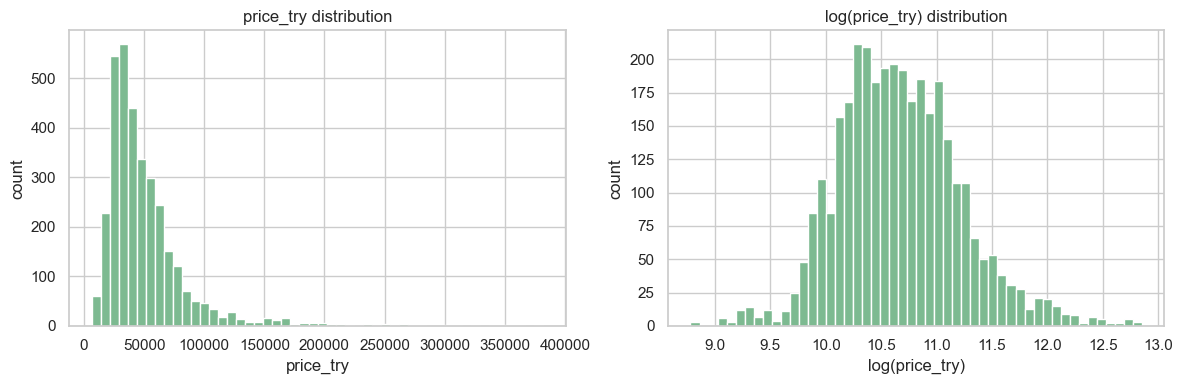

In [17]:
prices = df["price_try"].dropna()
log_prices = prices[prices > 0]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Orijinal fiyat dağılımı
axes[0].hist(prices, bins=50)
axes[0].set_title("price_try distribution")
axes[0].set_xlabel("price_try")
axes[0].set_ylabel("count")

# Log dönüşümlü fiyat dağılımı
axes[1].hist(np.log(log_prices), bins=50)
axes[1].set_title("log(price_try) distribution")
axes[1].set_xlabel("log(price_try)")
axes[1].set_ylabel("count")

plt.tight_layout()
plt.show()

##### 6.5 🧮 Sayısal Değişkenler Arası Korelasyon Analizi

Bu alt bölümde, veri setindeki **sayısal değişkenler arasındaki doğrusal ilişkiler** korelasyon matrisi ve ısı haritası (heatmap) kullanılarak incelenir. Özellikle hedef değişken olan **`price_try`** ile hangi özelliklerin daha güçlü ilişki gösterdiği belirlenmeye çalışılır.

##### 6.5.1 🔥 Korelasyon Matrisi ve Isı Haritası

Bu adımda:
- `select_dtypes(include="number")` ile yalnızca sayısal sütunlar seçilir.
- `corr()` fonksiyonu ile **Pearson korelasyon katsayıları** hesaplanır.
- `sns.heatmap(..., annot=True)` kullanılarak korelasyon matrisi görselleştirilir.
- Isı haritasındaki renk yoğunluğu, ilişkinin gücünü ve yönünü (pozitif / negatif) temsil eder.

##### 6.5.2 🔍 Fiyat (price_try) ile Olan İlişkilerin Yorumu

Isı haritası incelendiğinde `price_try` ile öne çıkan korelasyonlar şunlardır:

- **gpu_vram_gb (≈ 0.65)**  
  En güçlü pozitif ilişkiyi göstermektedir. Ekran kartı belleği, fiyatı açıklamada en önemli değişkenlerden biridir.
- **ssd_gb (≈ 0.55)**  
  Depolama kapasitesi arttıkça fiyatın da anlamlı biçimde arttığı görülmektedir.
- **refresh_rate_hz (≈ 0.54)**  
  Yüksek yenileme hızına sahip cihazlar genellikle daha pahalıdır (özellikle gaming segmenti).
- **ram_gb (≈ 0.53)**  
  RAM kapasitesi ile fiyat arasında belirgin ve pozitif bir ilişki vardır.
- **ppi (≈ 0.44)**  
  Ekran kalitesi (piksel yoğunluğu) fiyatla orta düzeyde ilişkilidir.
- **screen_size_inch (≈ 0.36)**  
  Ekran boyutu fiyat üzerinde etkili olmakla birlikte tek başına güçlü bir belirleyici değildir.
- **cpu_max_ghz (≈ 0.27)**  
  İşlemci frekansı fiyatla zayıf-orta düzeyde ilişkilidir.
- **cpu_generation (≈ 0.00)**  
  İşlemci nesli tek başına fiyatla anlamlı bir doğrusal ilişki göstermemektedir.

##### 6.5.3 🧠 Özellik Seçimi ve Modelleme Açısından Çıkarımlar

- **GPU VRAM, RAM, SSD kapasitesi ve yenileme hızı** fiyat tahmini için en güçlü aday özelliklerdir.
- Bazı değişkenler (ör. `cpu_generation`) doğrusal korelasyon göstermese bile, ağaç tabanlı modellerde dolaylı ve etkileşimli katkı sağlayabilir.
- Değişkenler arasında çok yüksek korelasyonlar sınırlıdır; bu durum ciddi bir **multicollinearity** problemi olmadığını göstermektedir.
- Korelasyon analizi, doğrusal ilişkileri ortaya koyar; doğrusal olmayan ilişkiler için ağaç tabanlı modeller veya etkileşim terimleri önemlidir.

Bu analizle birlikte, fiyat tahmini probleminde hangi sayısal özelliklerin daha açıklayıcı olduğu netleşmiş ve modelleme aşamasına geçiş için güçlü bir içgörü elde edilmiştir.

<Axes: >

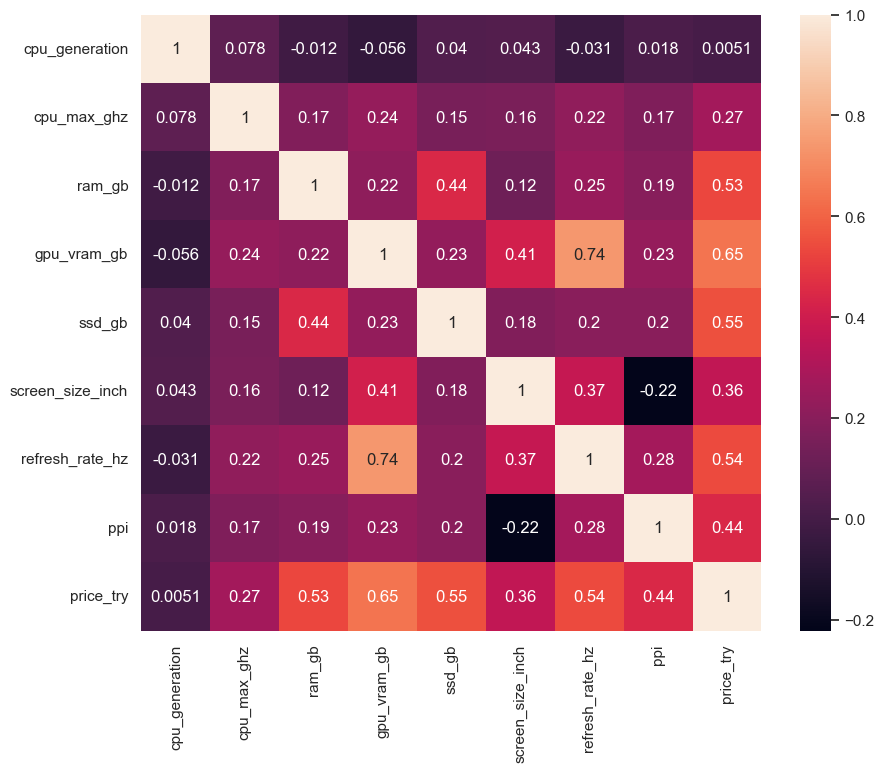

In [18]:
# numerical kolonlar arasindaki iliskiyi gozlemleyelim ve fiyat ile iliskili olanlari belirleyelim
df_corr = df.select_dtypes(include="number").corr()
plt.figure(figsize=(10, 8))
sns.heatmap(df_corr, annot=True)

#### 7. 🤖 Model Eğitimi: Veri Bölme ve Eğitim/Test Setlerinin Hazırlanması

Bu bölümde modelleme sürecine geçiyoruz. İlk adım olarak hedef değişken (`price_try`) ile özellikler ayrıştırılır, hedef değişkene **log dönüşümü** uygulanır ve veri seti **eğitim/test** olarak bölünür. Bu sayede modelleri adil biçimde eğitip, genellenebilirliğini test seti üzerinde değerlendirebiliriz.

#### 7.1 🧩 Feature-Target Ayrımı ve Log Dönüşümü

- `X`: Modelin girdi özellikleri olacak şekilde `price_try` sütunu çıkarılarak oluşturulur.
- `y`: Hedef değişken olarak `price_try` seçilir ve dağılımdaki sağa çarpıklığı azaltmak için `np.log(...)` ile log dönüşümü uygulanır.

#### 7.2 ✂️ Eğitim/Test Bölünmesi

Veri seti, performansı ölçmek için iki parçaya ayrılır:
- **%85 Eğitim (train)**: Modelin öğrenmesi için kullanılır.
- **%15 Test (test)**: Modelin hiç görmediği veride ne kadar iyi genellediğini ölçmek için kullanılır.

`random_state=2` değeri, bölmenin her çalıştırmada aynı şekilde yapılmasını sağlayarak sonuçların tekrarlanabilir olmasını garanti eder.

#### 7.3 👀 Eğitim Verisinden Örnek Görüntüleme

Son olarak `X_train.sample(5)` ile eğitim feature setinden rastgele 5 satır görüntülenerek bölme işleminin doğru çalıştığı hızlıca kontrol edilir.

In [19]:
from sklearn.model_selection import train_test_split

# Define feature matrix by removing the target column
X = df.drop(columns=["price_try"])
# Log-transform the target variable to normalize skewness
y = np.log(df["price_try"])


# Split the data into training and testing sets (85% train, 15% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=2
)

X_train.sample(5)  # View the training feature set

,brand,intended_use,color,weight,cpu_family,cpu_generation,cpu_max_ghz,ram_gb,ram_type,gpu_model,gpu_type,gpu_vram_gb,gpu_vram_type,ssd_gb,screen_size_inch,resolution,display_standard,refresh_rate_hz,panel_type,operating_system,ppi
760,lenovo,ofis-is,gri,1 - 2 kg,intel core i7,13.0,4.9,16.0,ddr5,intel integrated,integrated,0.0,shared,512.0,16.0,1920x1080,fhd,120.0,ips,windows pro,137.681698
1099,lenovo,ofis-is,gri,1 - 2 kg,intel core i7,13.0,5.0,32.0,ddr5,integrated,integrated,0.0,shared,1024.0,14.0,1920x1200,fhd,120.0,ips,windows pro,161.725391
3087,hp,ofis-is,gri,2 kg ve altı,intel core i7,13.0,4.6,16.0,ddr4,integrated,integrated,0.0,shared,1024.0,15.6,1920x1080,fhd,60.0,tn,windows home,141.211998
909,asus,ofis-is,mavi,2 kg ve altı,intel core i5,13.0,4.6,16.0,ddr4,intel integrated,integrated,0.0,ddr4,512.0,15.6,1920x1080,fhd,60.0,ips,freedos,141.211998
2046,lenovo,ofis-is,siyah,2 kg ve altı,intel core i5,12.0,4.4,16.0,ddr4,intel integrated,integrated,0.0,shared,512.0,15.6,1920x1080,fhd,60.0,tn,windows home,141.211998


##### 7.2 🧱 Modelleme Altyapısı: Pipeline, One-Hot Encoding ve Model Havuzu

Bu alt bölümde, farklı regresyon modellerini aynı veri hazırlama adımlarıyla kolayca eğitebilmek için **ortak bir modelleme altyapısı** kurulur. Kategorik değişkenlerin sayısallaştırılması için `OneHotEncoder` kullanılır ve tüm dönüşümler `ColumnTransformer` üzerinden tek bir yapıda yönetilir.

##### 7.2.1 📦 Gerekli Kütüphaneler ve Modellerin İçe Aktarılması

Bu adımda:
- **Ön işleme** bileşenleri: `ColumnTransformer`, `Pipeline`, `OneHotEncoder`
- **Regresyon modelleri**: `LinearRegression`, `Ridge`, `Lasso`, `KNeighborsRegressor`, `DecisionTreeRegressor`, `RandomForestRegressor`, `GradientBoostingRegressor`, `AdaBoostRegressor`, `ExtraTreesRegressor`, `SVR`, `XGBRegressor` vb.
- **Değerlendirme metrikleri**: `r2_score`, `mean_absolute_error`
- **Çapraz doğrulama**: `cross_val_score`
import edilerek deneme yapılacak model havuzu hazırlanır.

##### 7.2.2 🔕 Uyarı Yönetimi (Unknown Categories)

`OneHotEncoder(handle_unknown="ignore")` kullanıldığı için test setinde eğitimde görülmemiş kategori değerleri olsa bile hata alınmaz.  
Buna rağmen oluşabilecek kullanıcı uyarıları daha temiz bir çıktı için filtrelenir.

##### 7.2.3 🏷️ Kategorik Kolonların Seçilmesi (cat_idx)

Bu projede kategorik sütunlar, kolon isimleri yerine **indeks listesi** (`cat_idx`) ile belirlenmiştir.

- `cat_idx` listesi, one-hot encoding uygulanacak sütunların **kolon indekslerini** içerir.
- Bu yöntem, veri çerçevesi kolon sırası sabitse pratik bir çözümdür; ancak kolon sırası değişirse indekslerin güncellenmesi gerekir.

##### 7.2.4 🧬 One-Hot Encoding ve ColumnTransformer Kurulumu (step1)

`step1` değişkeni ile dönüşüm adımı tanımlanır:

- `OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop="first")`
  - `handle_unknown="ignore"`: bilinmeyen kategorileri hata vermeden görmezden gelir
  - `drop="first"`: dummy variable trap riskini azaltmak için her kategorik değişkende bir sınıfı düşürür
  - `sparse_output=False`: çıktıyı dense (numpy array) formatında döndürür

- `remainder="passthrough"`: kategorik olmayan tüm sayısal sütunlar olduğu gibi modele aktarılır.

##### 7.2.5 📝 Sonuçların Toplanması İçin Liste Oluşturma

`model_results = []` ile, ilerleyen adımlarda eğitilecek tüm modellerin performans metriklerini (R², MAE vb.) düzenli şekilde saklayacağımız bir liste hazırlanır.

In [ ]:

from sklearn.compose import (
    ColumnTransformer,
)  # For applying transformers to specific columns
from sklearn.pipeline import Pipeline  # To build sequential ML pipelines
from sklearn.preprocessing import OneHotEncoder  # For encoding categorical features
from sklearn.linear_model import LinearRegression, Ridge, Lasso  # Linear models
from sklearn.neighbors import KNeighborsRegressor  # K-Nearest Neighbors
from sklearn.tree import DecisionTreeRegressor  # Decision Tree
from sklearn.ensemble import (  # Ensemble models
    RandomForestRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor,
    ExtraTreesRegressor,
    VotingRegressor,
    StackingRegressor,
)
from sklearn.svm import SVR  # Support Vector Regressor
from xgboost import XGBRegressor  # Extreme Gradient Boosting Regressor

from sklearn.metrics import r2_score, mean_absolute_error  # Evaluation metrics
from sklearn.model_selection import cross_val_score  # For cross-validation
import warnings
from sklearn.exceptions import DataConversionWarning

warnings.filterwarnings(
    "ignore", message="Found unknown categories in columns*", category=UserWarning
)
# X_train dataframe ise kolon indexleri aynen kullanılabilir
cat_idx = [0, 1, 2, 3, 4, 8, 9, 10, 12, 15, 16, 18, 19]
#cat_idx = [0, 1, 5, 6, 8, 11, 13, 14,]
step1 = ColumnTransformer(
    transformers=[
        (
            "col_tnf",
            OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop="first"),
            cat_idx,
        )
    ],
    remainder="passthrough",
)
# Store results for all models
model_results = []

##### 7.3 🧾 Model Değerlendirme Fonksiyonu: Eğitim/Test Skorları, CV ve TRY Bazlı Hata

Bu alt bölümde, farklı modelleri aynı standartta değerlendirmek ve sonuçları tek bir yapıda toplamak için modüler bir fonksiyon tanımlanır: `eval_and_log_model(...)`.  
Fonksiyon; pipeline kurulumundan başlayarak modeli eğitir, eğitim/test tahminlerini üretir, metrikleri hesaplar ve sonuçları `model_results` listesine ekler.

##### 7.3.1 🧩 Pipeline Kurulumu ve Modelin Eğitilmesi

- `Pipeline([("step1", step1), ("step2", model)])` ile:
  - `step1`: One-Hot Encoding + passthrough dönüşümleri
  - `step2`: İlgili regresyon modeli
  tek bir boru hattında birleştirilir.
- `pipe.fit(X_train, y_train)` ile model eğitim verisi üzerinde öğrenir.

##### 7.3.2 🎯 Eğitim/Test Tahminleri ve Temel Metrikler

Model eğitildikten sonra:
- `pipe.predict(X_train)` ve `pipe.predict(X_test)` ile train/test tahminleri alınır.
- Performans şu metriklerle ölçülür:
  - `R2_train`, `R2_test`: Açıklanan varyans oranı (R²)
  - `MAE_train`, `MAE_test`: Ortalama mutlak hata (log hedef uzayında)

##### 7.3.3 🔁 Çapraz Doğrulama ile Genellenebilirlik Kontrolü

- `cross_val_score(..., scoring="r2")` kullanılarak eğitim seti üzerinde `cv` katlı doğrulama yapılır.
- `CV_R2_train_mean`, modelin tek bir train/test bölünmesine aşırı bağlı kalmadan genel performansını görmemizi sağlar.

##### 7.3.4 💸 TRY Bazında MAE Hesabı (Log Hedefi Geri Çevirme)

Hedef değişken log dönüşümlü olduğu için, hatayı gerçek fiyat ölçeğinde (TRY) yorumlamak daha anlamlıdır.

- Fonksiyon, hedefin log olup olmadığını basit bir sezgisel kontrolle belirler:
  - `target_is_log` ≈ `median(y_train) < 50`
- Eğer hedef log ise:
  - `np.exp(...)` ile orijinal fiyat ölçeğine geri dönülür
  - `MAE_TRY_train` ve `MAE_TRY_test` hesaplanır
- Değilse doğrudan MAE hesaplanır.

##### 7.3.5 🗂️ Sonuçların Kaydedilmesi ve Konsola Yazdırılması

Fonksiyon:
- Tüm metrikleri `row` sözlüğüne toplar.
- `model_results.append(row)` ile sonuçları bir listeye ekler (sonradan tablo/rapor üretmek için).
- Ekrana özet performans çıktısı basar.

Fonksiyon çıktısı olarak:
- Eğitilmiş `pipe` (pipeline)
- İlgili modelin metriklerini içeren `row`
geri döndürülür.

In [21]:
def eval_and_log_model(
    name, model, step1, X_train, y_train, X_test, y_test, model_results, cv=5
):
    pipe = Pipeline([("step1", step1), ("step2", model)])
    pipe.fit(X_train, y_train)

    y_pred_train = pipe.predict(X_train)
    y_pred_test = pipe.predict(X_test)

    r2_train = float(r2_score(y_train, y_pred_train))
    mae_train = float(mean_absolute_error(y_train, y_pred_train))
    r2_test = float(r2_score(y_test, y_pred_test))
    mae_test = float(mean_absolute_error(y_test, y_pred_test))

    cv_r2 = float(cross_val_score(pipe, X_train, y_train, cv=cv, scoring="r2").mean())

    # hedef log mu? (heuristic)
    is_log_target = float(np.nanmedian(y_train)) < 50

    if is_log_target:
        mae_try_train = float(np.mean(np.abs(np.exp(y_train) - np.exp(y_pred_train))))
        mae_try_test = float(np.mean(np.abs(np.exp(y_test) - np.exp(y_pred_test))))
    else:
        mae_try_train = float(np.mean(np.abs(y_train - y_pred_train)))
        mae_try_test = float(np.mean(np.abs(y_test - y_pred_test)))

    row = {
        "Model": name,
        "R2_train": r2_train,
        "R2_test": r2_test,
        "MAE_train": mae_train,
        "MAE_test": mae_test,
        "MAE_TRY_train": mae_try_train,
        "MAE_TRY_test": mae_try_test,
        "CV_R2_train_mean": cv_r2,
        "target_is_log": bool(is_log_target),
    }
    model_results.append(row)

    print(f"\n=== {name} ===")
    print("Train R²:", r2_train, "| Test R²:", r2_test, "| CV R²:", cv_r2)
    print("Train MAE:", mae_train, "| Test MAE:", mae_test)
    print("Train MAE (TRY):", mae_try_train, "| Test MAE (TRY):", mae_try_test)

    return pipe, row

#### 8. 🧪 Modellerin Denenmesi ve Karşılaştırılması

Bu bölümde, hazırlanan `eval_and_log_model(...)` fonksiyonu kullanılarak farklı regresyon modelleri aynı veri hazırlama (encoding + passthrough) adımlarıyla eğitilir ve performansları karşılaştırılır. Her model için eğitim/test skorları, çapraz doğrulama (CV) sonucu ve hatanın gerçek fiyat ölçeğindeki (TRY) karşılığı raporlanır.

#### 8.1 📏 Linear Regression (Doğrusal Regresyon)

Bu alt başlıkta temel bir referans model olan **Linear Regression** eğitilir. Doğrusal regresyon, veri ile hedef arasında doğrusal bir ilişki varsayar ve genellikle karşılaştırma için iyi bir başlangıç noktasıdır.

##### 8.1.1 ✅ Sonuçların Özeti

- **Train R²:** 0.8765  
- **Test R²:** 0.8695  
- **CV R² (mean):** 0.8020  

- **Train MAE (log):** 0.1363  
- **Test MAE (log):** 0.1390  

- **Train MAE (TRY):** 7,314  
- **Test MAE (TRY):** 6,817  

##### 8.1.2 🔍 Yorum

- Train ve Test R² değerlerinin birbirine çok yakın olması, modelin **aşırı öğrenme (overfitting)** yapmadığını ve genellenebilirliğinin iyi olduğunu gösterir.
- CV R² değerinin (0.802) test R²’den daha düşük olması, farklı katlamalarda performansın bir miktar dalgalandığını; yani veri bölünmesine göre değişim olabileceğini işaret eder.
- TRY bazlı hataya bakıldığında model, ortalama olarak test setinde yaklaşık **~6.8K TL** sapma ile tahmin yapmaktadır. Bu, başlangıç (baseline) için makul bir seviye olup daha güçlü modellerle kıyaslamak için iyi bir referans oluşturur.

> Not: Doğrusal regresyon; RAM/SSD/GPU gibi özelliklerin fiyatla ilişkisini yakalayabilir, fakat etkileşimler ve doğrusal olmayan ilişkiler (ör. GPU VRAM ve refresh rate gibi kırılımlar) için sınırlı kalabilir. Bu yüzden ilerleyen modellerde performans artışı beklenir.

In [22]:
pipe_lr, lr_row = eval_and_log_model(
    name="LinearRegression",
    model=LinearRegression(),
    step1=step1,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    model_results=model_results,
    cv=5,
)


=== LinearRegression ===
Train R²: 0.8764946526592388 | Test R²: 0.8695485343995135 | CV R²: 0.8020350430613774
Train MAE: 0.1362612740097676 | Test MAE: 0.13897300949891223
Train MAE (TRY): 7314.205561157299 | Test MAE (TRY): 6816.6427310822455


##### 8.2 🧮 Ridge Regression (alpha = 10)

Bu alt başlıkta, **L2 düzenlileştirme (regularization)** kullanan Ridge Regression modeli değerlendirilmiştir. Ridge, doğrusal regresyona kıyasla katsayıları cezalandırarak modelin aşırı karmaşık hale gelmesini engellemeyi amaçlar. Özellikle çok sayıda one-hot encoded özellik bulunan veri setlerinde daha dengeli sonuçlar üretebilir.

##### 8.2.1 ✅ Sonuçların Özeti

- **Train R²:** 0.8507  
- **Test R²:** 0.8598  
- **CV R² (mean):** 0.8294  

- **Train MAE (log):** 0.1491  
- **Test MAE (log):** 0.1437  

- **Train MAE (TRY):** 7,950  
- **Test MAE (TRY):** 6,911  

##### 8.2.2 🔍 Yorum

- Train ve Test R² değerlerinin birbirine yakın olması, Ridge modelinin **dengeli ve stabil** bir genelleme performansı sunduğunu göstermektedir.
- CV R² değerinin (0.829) test R²’den daha yüksek olması, modelin farklı veri bölünmelerinde **daha tutarlı** çalıştığına işaret eder.
- Ancak, Linear Regression ile karşılaştırıldığında:
  - Test R² biraz daha düşük
  - TRY bazlı hata biraz daha yüksek (~6.9K TL)
- Bu durum, düzenlileştirmenin varyansı azaltırken bir miktar **bias** eklediğini göstermektedir.

> Değerlendirme: Ridge Regression, yüksek boyutlu ve çoklu korelasyon içeren feature setleri için güvenli bir alternatif olsa da, bu problem özelinde Linear Regression’a kıyasla belirgin bir performans avantajı sağlamamıştır. Daha karmaşık ve doğrusal olmayan modellerden iyileşme beklenmektedir.

In [ ]:
pipe_ridge10, ridge10_row = eval_and_log_model(
    name="Ridge(alpha=10)",
    model=Ridge(alpha=10),
    step1=step1,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    model_results=model_results,
    cv=5,
)


=== Ridge(alpha=10) ===
Train R²: 0.850674554764839 | Test R²: 0.8598259876465499 | CV R²: 0.8294229525821173
Train MAE: 0.14907811218747227 | Test MAE: 0.14367161793947655
Train MAE (TRY): 7950.415651547576 | Test MAE (TRY): 6911.401096463806


##### 8.3 ✂️ Lasso Regression (alpha = 0.001)

Bu alt başlıkta, **L1 düzenlileştirme (regularization)** kullanan Lasso Regression modeli değerlendirilmiştir. Lasso, bazı katsayıları sıfıra indirerek **özellik seçimi (feature selection)** yapabilmesiyle öne çıkar. Bu sayede daha sade ve yorumlanabilir modeller üretmeyi hedefler.

##### 8.3.1 ✅ Sonuçların Özeti

- **Train R²:** 0.8353  
- **Test R²:** 0.8494  
- **CV R² (mean):** 0.8221  

- **Train MAE (log):** 0.1563  
- **Test MAE (log):** 0.1504  

- **Train MAE (TRY):** 8,493  
- **Test MAE (TRY):** 7,256  

##### 8.3.2 🔍 Yorum

- Test R² değerinin train R²’den yüksek olması, modelin **overfitting yapmadığını**, hatta biraz **underfitting** eğiliminde olduğunu göstermektedir.
- TRY bazlı hata (~7.3K TL), Linear ve Ridge modellere kıyasla daha yüksektir.
- L1 cezası, bazı one-hot encoded özelliklerin tamamen devre dışı kalmasına yol açmış olabilir; bu da bu veri setinde fiyat tahmini için gerekli bilgilerin bir kısmının kaybolmasına neden olmuştur.
- CV R² değerinin (0.822) orta seviyede kalması, modelin farklı veri bölünmelerinde tutarlı ancak sınırlı bir performans sunduğunu göstermektedir.

> Değerlendirme: Lasso Regression, **özellik seçimi** açısından faydalı bir araç olsa da, bu problemde tahmin doğruluğu öncelikli olduğundan performansı Linear ve Ridge modellerin gerisinde kalmıştır. Daha çok model sadeleştirme veya yorumlanabilirlik odaklı senaryolar için tercih edilebilir.

In [24]:
pipe_lasso, lasso_row = eval_and_log_model(
    name="Lasso(alpha=0.001)",
    model=Lasso(alpha=0.001, max_iter=20000),
    step1=step1,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    model_results=model_results,
    cv=5,
)


=== Lasso(alpha=0.001) ===
Train R²: 0.8353432501519384 | Test R²: 0.8493916105847582 | CV R²: 0.8221211235702816
Train MAE: 0.15625875874192324 | Test MAE: 0.15044888287874525
Train MAE (TRY): 8493.17750467359 | Test MAE (TRY): 7255.754919368462


##### 8.4 📍 K-Nearest Neighbors Regressor (KNN, k = 3)

Bu alt başlıkta, örnek tabanlı (instance-based) bir yöntem olan **K-Nearest Neighbors Regression** modeli değerlendirilmiştir. KNN, tahmin yaparken bir gözlemin hedef değerini, ona en yakın `k` komşunun hedef değerlerinin ortalaması üzerinden hesaplar. Bu nedenle veri dağılımına oldukça duyarlıdır ve ölçek/yoğunluk yapısından doğrudan etkilenir.

##### 8.4.1 ✅ Sonuçların Özeti

- **Train R²:** 0.9050  
- **Test R²:** 0.7903  
- **CV R² (mean):** 0.7765  

- **Train MAE (log):** 0.1143  
- **Test MAE (log):** 0.1706  

- **Train MAE (TRY):** 6,175  
- **Test MAE (TRY):** 8,299  

##### 8.4.2 🔍 Yorum

- Train R² değerinin oldukça yüksek (0.905) olmasına karşın Test R²’nin belirgin şekilde düşmesi, modelin **overfitting** eğiliminde olduğunu göstermektedir.
- Eğitim setinde hata düşükken (≈ 6.2K TL), test setinde hatanın ciddi biçimde artması (≈ 8.3K TL), KNN’nin genelleme kabiliyetinin zayıf kaldığını ortaya koymaktadır.
- CV R² değerinin (0.776) düşük olması da bu durumu desteklemektedir; model farklı katlamalarda tutarlı performans sergileyememektedir.
- One-hot encoding sonrası oluşan **yüksek boyutlu feature space**, KNN gibi mesafe temelli algoritmalar için dezavantaj oluşturmuştur (curse of dimensionality).

> Değerlendirme: KNN (k=3), eğitim verisini çok iyi ezberlemesine rağmen test verisinde başarım kaybetmiştir. Bu problem özelinde KNN, özellikle yüksek boyutlu ve kategorik ağırlıklı veri yapısı nedeniyle uygun bir tercih değildir. Daha büyük `k` değerleri veya ölçekleme ile kısmi iyileştirme mümkün olsa da, genel olarak ağaç tabanlı ve boosting yöntemlerin daha başarılı olması beklenmektedir.

In [25]:
pipe_knn3, knn3_row = eval_and_log_model(
    name="KNN(n_neighbors=3)",
    model=KNeighborsRegressor(n_neighbors=3),
    step1=step1,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    model_results=model_results,
    cv=5,
)


=== KNN(n_neighbors=3) ===
Train R²: 0.9050483823571063 | Test R²: 0.7902670306373092 | CV R²: 0.7765412730247385
Train MAE: 0.11429910599945803 | Test MAE: 0.1706094356309216
Train MAE (TRY): 6174.670960486667 | Test MAE (TRY): 8299.406764948551


##### 8.5 🌳 Decision Tree Regressor (max_depth = 8)

Bu alt başlıkta, doğrusal olmayan ilişkileri ve feature etkileşimlerini yakalayabilen **Decision Tree Regressor** modeli değerlendirilmiştir. Ağaç derinliği `max_depth=8` ile sınırlandırılarak modelin aşırı karmaşık hale gelmesi (overfitting) kontrol altında tutulmaya çalışılmıştır.

##### 8.5.1 ✅ Sonuçların Özeti

- **Train R²:** 0.8691  
- **Test R²:** 0.8038  
- **CV R² (mean):** 0.7529  

- **Train MAE (log):** 0.1428  
- **Test MAE (log):** 0.1709  

- **Train MAE (TRY):** 6,383  
- **Test MAE (TRY):** 8,029  

##### 8.5.2 🔍 Yorum

- Train R² ile Test R² arasındaki farkın artması, Decision Tree modelinin **kısmi overfitting** eğilimi gösterdiğini işaret etmektedir.
- Test setindeki TRY bazlı hata (~8.0K TL), doğrusal modellere kıyasla daha yüksektir.
- CV R² değerinin (0.753) düşük kalması, modelin farklı veri bölünmelerinde kararsız performans sergilediğini göstermektedir.
- Tek bir karar ağacı, karmaşık veri yapısını yakalayabilse de **yüksek varyans** problemi nedeniyle genelleme kabiliyeti sınırlı kalmaktadır.

> Değerlendirme: Decision Tree, doğrusal olmayan ilişkileri yakalama avantajına sahip olsa da, tek başına kullanıldığında bu problemde yeterli genelleme başarısını sağlayamamıştır. Bu sonuç, **Random Forest, Gradient Boosting ve XGBoost** gibi ensemble yöntemlerin neden tercih edildiğini açıkça göstermektedir.

In [ ]:
pipe_dt8, dt8_row = eval_and_log_model(
    name="DecisionTreeRegressor(max_depth=8)",
    model=DecisionTreeRegressor(max_depth=8, random_state=42),
    step1=step1,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    model_results=model_results,
    cv=5,
)


=== DecisionTreeRegressor(max_depth=8) ===
Train R²: 0.8691070574173413 | Test R²: 0.8038251212729899 | CV R²: 0.7528655695657944
Train MAE: 0.14275329659917407 | Test MAE: 0.17087931691223032
Train MAE (TRY): 6383.276533442221 | Test MAE (TRY): 8028.725858410049


##### 8.6 🌀 Support Vector Regressor (RBF Kernel)

Bu alt başlıkta, doğrusal olmayan ilişkileri çekirdek (kernel) fonksiyonu yardımıyla modelleyebilen **Support Vector Regressor (SVR)** değerlendirilmiştir. RBF (Radial Basis Function) kernel, özellikle karmaşık ve doğrusal olmayan veri yapılarında güçlü bir temsil yeteneği sunar.

Model konfigürasyonu:
- `kernel="rbf"`
- `C = 10000` (ceza parametresi)
- `epsilon = 0.1` (hata toleransı)

##### 8.6.1 ✅ Sonuçların Özeti

- **Train R²:** 0.8646  
- **Test R²:** 0.8694  
- **CV R² (mean):** 0.8413  

- **Train MAE (log):** 0.1333  
- **Test MAE (log):** 0.1352  

- **Train MAE (TRY):** 6,626  
- **Test MAE (TRY):** 6,557  

##### 8.6.2 🔍 Yorum

- Train ve Test R² değerlerinin neredeyse aynı olması, SVR modelinin **çok dengeli bir genelleme** performansı sunduğunu göstermektedir.
- CV R² değerinin (0.841) yüksek olması, modelin farklı katlamalarda da **istikrarlı** sonuçlar ürettiğine işaret eder.
- TRY bazlı test hatasının (~6.6K TL), şimdiye kadar denenmiş birçok modelden daha düşük olması dikkat çekicidir.
- SVR, doğrusal modellerin yakalayamadığı karmaşık ilişkileri öğrenebilmiş; ancak bu başarı, yüksek `C` değeri nedeniyle **hesaplama maliyeti** açısından pahalı olabilir.

> Değerlendirme: SVR (RBF), bu problem için **güçlü ve dengeli bir aday model** olarak öne çıkmaktadır. Performans açısından Linear/Ridge modellerden daha iyi, ancak eğitim süresi ve ölçeklenebilirlik bakımından büyük veri setlerinde dikkatli kullanılmalıdır. Ensemble yöntemlerle karşılaştırılması kritik olacaktır.

In [27]:
pipe_svr, svr_row = eval_and_log_model(
    name="SVR(rbf, C=10000, eps=0.1)",
    model=SVR(kernel="rbf", C=10000, epsilon=0.1),
    step1=step1,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    model_results=model_results,
    cv=5,
)



=== SVR(rbf, C=10000, eps=0.1) ===
Train R²: 0.864554497655698 | Test R²: 0.8694302663421964 | CV R²: 0.841302968097198
Train MAE: 0.13330645252673737 | Test MAE: 0.1352087116837147
Train MAE (TRY): 6625.928146248794 | Test MAE (TRY): 6557.028790614336


##### 8.7 🌲 Random Forest Regressor

Bu alt başlıkta, çok sayıda karar ağacının bir araya gelmesiyle oluşturulan **Random Forest Regressor** modeli değerlendirilmiştir. Random Forest, tek bir karar ağacına kıyasla varyansı düşürür ve doğrusal olmayan ilişkileri daha güçlü biçimde yakalayabilir.

Kullanılan temel hiperparametreler:
- `n_estimators = 100`
- `max_depth = 15`
- `max_samples = 0.5`
- `max_features = 0.75`
- `n_jobs = -1` (paralel çalışma)

##### 8.7.1 ✅ Sonuçların Özeti

- **Train R²:** 0.9413  
- **Test R²:** 0.8859  
- **CV R² (mean):** 0.8610  

- **Train MAE (log):** 0.0890  
- **Test MAE (log):** 0.1217  

- **Train MAE (TRY):** 4,612  
- **Test MAE (TRY):** 6,025  

##### 8.7.2 🔍 Yorum

- Train R²’nin oldukça yüksek olması, modelin eğitim verisini çok iyi öğrendiğini göstermektedir.
- Test R²’nin (0.886) güçlü seviyede kalması ve CV R²’nin (0.861) yüksek olması, modelin **genellenebilirliğinin iyi** olduğunu ortaya koymaktadır.
- TRY bazlı test hatasının (~6.0K TL), şimdiye kadar denenmiş modeller arasında **en düşük seviyelerden biri** olduğu görülmektedir.
- `max_samples` ve `max_features` ile yapılan alt örnekleme, overfitting riskini azaltarak daha dengeli bir performans sağlamıştır.

> **Değerlendirme:** Random Forest, doğrusal olmayan ilişkileri ve feature etkileşimlerini başarıyla yakalayarak bu problem için **çok güçlü bir aday** olduğunu kanıtlamıştır. Performans–istikrar dengesi açısından, şu ana kadar denenmiş modeller arasında üst sıralarda yer almaktadır. Gradient Boosting ve XGBoost gibi boosting tabanlı yöntemlerle kıyaslandığında nihai tercih netleşecektir.

In [28]:
pipe_rf, rf_row = eval_and_log_model(
    name="RandomForest(n=100, depth=15, max_samples=0.5, max_features=0.75)",
    model=RandomForestRegressor(
        n_estimators=100,
        random_state=3,
        max_samples=0.5,
        max_features=0.75,
        max_depth=15,
        n_jobs=-1,
    ),
    step1=step1,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    model_results=model_results,
    cv=5,
)


=== RandomForest(n=100, depth=15, max_samples=0.5, max_features=0.75) ===
Train R²: 0.9413168345338941 | Test R²: 0.8859363299778411 | CV R²: 0.8609850195496016
Train MAE: 0.08900358888014055 | Test MAE: 0.12171635241394296
Train MAE (TRY): 4612.176650806584 | Test MAE (TRY): 6025.04055039655


##### 8.8 🌲 Extra Trees Regressor (Extremely Randomized Trees)

Bu alt başlıkta, Random Forest’a benzer bir ensemble yöntem olan **Extra Trees Regressor** değerlendirilmiştir. Extra Trees, ağaçları oluştururken bölünme noktalarında daha fazla rastgelelik kullanarak **varyansı düşürmeyi** ve genelleme performansını artırmayı hedefler.

Kullanılan temel hiperparametreler:
- `n_estimators = 100`
- `max_depth = 15`
- `max_samples = 0.5`
- `max_features = 0.75`
- `bootstrap = True`
- `n_jobs = -1`

##### 8.8.1 ✅ Sonuçların Özeti

- **Train R²:** 0.9417  
- **Test R²:** 0.8930  
- **CV R² (mean):** 0.8682  

- **Train MAE (log):** 0.0892  
- **Test MAE (log):** 0.1192  

- **Train MAE (TRY):** 4,701  
- **Test MAE (TRY):** 5,899  

##### 8.8.2 🔍 Yorum

- Train ve Test R² değerlerinin yüksek ve birbirine oldukça yakın olması, modelin **güçlü ama dengeli** bir öğrenme gerçekleştirdiğini göstermektedir.
- CV R² değerinin (0.868) şimdiye kadar görülen **en yüksek** değerlerden biri olması, Extra Trees modelinin farklı veri bölünmelerinde **son derece istikrarlı** olduğunu ortaya koymaktadır.
- TRY bazlı test hatasının (~5.9K TL), Random Forest’tan daha düşük olması, Extra Trees’in fiyat tahmini açısından **bir miktar daha başarılı** olduğunu göstermektedir.
- Bölünmelerdeki ekstra rastgelelik, modelin overfitting riskini azaltarak genelleme kabiliyetini güçlendirmiştir.

> **Değerlendirme:** Extra Trees Regressor, şu ana kadar denenmiş modeller arasında **en iyi performans gösteren adaylardan biri** olarak öne çıkmaktadır. Hem Test R² hem de TRY bazlı hata açısından Random Forest ve SVR’ı geride bırakmıştır. Nihai model seçimi aşamasında güçlü bir referans model olarak değerlendirilmelidir.

In [29]:
pipe_et, et_row = eval_and_log_model(
    name="ExtraTrees(n=100, depth=15, max_samples=0.5, max_features=0.75, bootstrap=True)",
    model=ExtraTreesRegressor(
        n_estimators=100,
        random_state=3,
        max_samples=0.5,
        max_features=0.75,
        max_depth=15,
        bootstrap=True,
        n_jobs=-1,
    ),
    step1=step1,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    model_results=model_results,
    cv=5,
)


=== ExtraTrees(n=100, depth=15, max_samples=0.5, max_features=0.75, bootstrap=True) ===
Train R²: 0.9417198813541641 | Test R²: 0.8929851084276601 | CV R²: 0.8681560383267113
Train MAE: 0.08922146879634466 | Test MAE: 0.11917559025272564
Train MAE (TRY): 4700.98623082575 | Test MAE (TRY): 5898.5186433017125


##### 8.9 🚀 AdaBoost Regressor

Bu alt başlıkta, zayıf öğrenicileri (weak learners) ardışık olarak eğiterek hatalara odaklanan bir boosting yöntemi olan **AdaBoost Regressor** değerlendirilmiştir. AdaBoost, genellikle basit karar ağaçları ile birlikte kullanılır ve hatalı tahmin edilen örneklere daha fazla ağırlık vererek öğrenmeyi sürdürür.

Kullanılan temel hiperparametreler:
- `n_estimators = 15`
- `learning_rate = 1.0`
- `random_state = 42`

##### 8.9.1 ✅ Sonuçların Özeti

- **Train R²:** 0.7134  
- **Test R²:** 0.7014  
- **CV R² (mean):** 0.6805  

- **Train MAE (log):** 0.2338  
- **Test MAE (log):** 0.2313  

- **Train MAE (TRY):** 12,023  
- **Test MAE (TRY):** 11,577  

##### 8.9.2 🔍 Yorum

- Hem Train hem de Test R² değerlerinin düşük olması, AdaBoost modelinin bu veri setinde **yetersiz kaldığını** göstermektedir.
- TRY bazlı hata (~11–12K TL), şimdiye kadar denenmiş tüm modeller arasında **en yüksek** seviyededir.
- Düşük sayıda estimator (`n_estimators=15`) ve temel öğrenicinin sınırlı kapasitesi, karmaşık fiyat ilişkilerini yakalamakta başarısız olmuştur.
- CV R² değerinin (0.681) düşük olması, modelin farklı veri bölünmelerinde de tutarsız performans sergilediğini göstermektedir.

> **Değerlendirme:** AdaBoost Regressor, bu problem özelinde uygun bir model olarak öne çıkmamıştır. Daha derin ağaçlar, daha yüksek `n_estimators` veya farklı boosting yaklaşımları (özellikle **Gradient Boosting** ve **XGBoost**) ile anlamlı performans artışı beklenebilir.

In [30]:
# 2) AdaBoost (base estimator belirtmek istersen: DecisionTree(max_depth=3))
pipe_ada, ada_row = eval_and_log_model(
    name="AdaBoost(n=15, lr=1.0)",
    model=AdaBoostRegressor(
        n_estimators=15,
        learning_rate=1.0,
        random_state=42,
        # estimator=DecisionTreeRegressor(max_depth=3, random_state=42)  # sklearn>=1.2
    ),
    step1=step1,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    model_results=model_results,
    cv=5,
)


=== AdaBoost(n=15, lr=1.0) ===
Train R²: 0.7133839641774875 | Test R²: 0.7014135141117901 | CV R²: 0.6805114283352852
Train MAE: 0.2337560274834236 | Test MAE: 0.2312693620076066
Train MAE (TRY): 12023.362428532308 | Test MAE (TRY): 11576.738280824693


##### 8.10 📈 Gradient Boosting Regressor (n_estimators = 500)

Bu alt başlıkta, ardışık olarak kurulan karar ağaçlarıyla hataları kademeli biçimde azaltan güçlü bir boosting yöntemi olan **Gradient Boosting Regressor** değerlendirilmiştir. Gradient Boosting, özellikle doğrusal olmayan ilişkiler ve feature etkileşimlerini yakalamada oldukça etkilidir.

Kullanılan temel hiperparametre:
- `n_estimators = 500`
- `random_state = 42`

##### 8.10.1 ✅ Sonuçların Özeti

- **Train R²:** 0.9440  
- **Test R²:** 0.8980  
- **CV R² (mean):** 0.8667  

- **Train MAE (log):** 0.0936  
- **Test MAE (log):** 0.1170  

- **Train MAE (TRY):** 4,521  
- **Test MAE (TRY):** 5,624  

##### 8.10.2 🔍 Yorum

- Train R²’nin yüksek olması, modelin eğitim verisini çok iyi öğrendiğini göstermektedir.
- Test R²’nin (0.898) şimdiye kadar elde edilen **en yüksek** değerlerden biri olması, modelin güçlü bir genelleme performansı sunduğunu göstermektedir.
- CV R² değerinin (0.867) yüksek ve Test R²’ye yakın olması, modelin **istikrarlı** çalıştığını ortaya koymaktadır.
- TRY bazlı test hatasının (~5.6K TL), önceki tüm modellerden daha düşük olması, Gradient Boosting’in fiyat tahmini açısından **çok güçlü** bir performans sergilediğini göstermektedir.

> **Değerlendirme:** Gradient Boosting Regressor, şu ana kadar denenmiş modeller arasında **en iyi performansı gösteren modellerden biri** olmuştur. Hem doğruluk hem de hata metrikleri açısından Extra Trees ile birlikte zirvede yer almaktadır. XGBoost gibi daha gelişmiş boosting yöntemleriyle yapılacak karşılaştırma, nihai model seçimini netleştirecektir.

In [31]:
# 3) GradientBoosting (500 estimator)
pipe_gb500, gb500_row = eval_and_log_model(
    name="GradientBoosting(n=500)",
    model=GradientBoostingRegressor(n_estimators=500, random_state=42),
    step1=step1,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    model_results=model_results,
    cv=5,
)


=== GradientBoosting(n=500) ===
Train R²: 0.9440168366961825 | Test R²: 0.8980034111279867 | CV R²: 0.8667003130209755
Train MAE: 0.09357102512126374 | Test MAE: 0.11704316735829644
Train MAE (TRY): 4521.238324988808 | Test MAE (TRY): 5624.043899693101


##### 8.11 ⚡ XGBoost Regressor (n_estimators = 45, max_depth = 5, learning_rate = 0.5)

Bu alt başlıkta, gradient boosting yaklaşımının optimize edilmiş ve yüksek performanslı bir uygulaması olan **XGBoost Regressor** değerlendirilmiştir. XGBoost; düzenlileştirme, paralel hesaplama ve gelişmiş optimizasyon teknikleri sayesinde özellikle tabular verilerde güçlü sonuçlar üretebilir.

Kullanılan temel hiperparametreler:
- `n_estimators = 45`
- `max_depth = 5`
- `learning_rate = 0.5`
- `random_state = 42`

##### 8.11.1 ✅ Sonuçların Özeti

- **Train R²:** 0.9487  
- **Test R²:** 0.8816  
- **CV R² (mean):** 0.8588  

- **Train MAE (log):** 0.0905  
- **Test MAE (log):** 0.1289  

- **Train MAE (TRY):** 4,442  
- **Test MAE (TRY):** 6,355  

##### 8.11.2 🔍 Yorum

- Train R² değerinin çok yüksek olması, modelin eğitim verisini oldukça iyi öğrendiğini göstermektedir.
- Test R²’nin (0.882), Gradient Boosting ve Extra Trees’e kıyasla daha düşük kalması, modelin bu konfigürasyonda **kısmi overfitting** eğilimi gösterebileceğine işaret etmektedir.
- TRY bazlı test hatasının (~6.35K TL), Gradient Boosting (~5.6K TL) ve Extra Trees (~5.9K TL) modellerinden daha yüksek olması dikkat çekicidir.
- Yüksek `learning_rate` (0.5) ve düşük ağaç sayısı, modelin hızlı öğrenmesine yol açmış; ancak bu durum genelleme performansını sınırlamış olabilir.

> **Değerlendirme:** XGBoost Regressor güçlü bir algoritma olmasına rağmen, bu deneyde kullanılan hiperparametrelerle **en iyi sonuçları veren model olmamıştır**. Daha düşük `learning_rate`, daha fazla `n_estimators` ve düzenlileştirme parametreleri (`subsample`, `colsample_bytree`, `reg_alpha`, `reg_lambda`) ile yapılacak bir hiperparametre optimizasyonu, XGBoost’un performansını belirgin şekilde artırabilir.

In [32]:
pipe_xgb, xgb_row = eval_and_log_model(
    name="XGBRegressor(n=45, depth=5, lr=0.5)",
    model=XGBRegressor(
        n_estimators=45,
        max_depth=5,
        learning_rate=0.5,
        verbosity=0,
        random_state=42,
    ),
    step1=step1,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    model_results=model_results,
    cv=5,
)


=== XGBRegressor(n=45, depth=5, lr=0.5) ===
Train R²: 0.948650374520751 | Test R²: 0.8816185559186729 | CV R²: 0.8587562486756675
Train MAE: 0.0905340144868185 | Test MAE: 0.12893489135272027
Train MAE (TRY): 4442.278661668745 | Test MAE (TRY): 6354.769536741952


##### 8.12 🗳️ Voting Regressor (Ağırlıklı Ensemble)

Bu alt başlıkta, birden fazla güçlü modeli tek bir tahminde birleştiren **Voting Regressor** değerlendirilmiştir. Voting Regressor, her bir alt modelin tahminlerini ağırlıklı ortalama ile birleştirerek daha dengeli ve genellenebilir sonuçlar üretmeyi amaçlar.

Bu çalışmada kullanılan ensemble bileşenleri:
- **Random Forest** (ağırlık: 5)
- **Gradient Boosting**
- **XGBoost**
- **Extra Trees**

Random Forest modeline daha yüksek ağırlık verilerek, önceki deneylerde güçlü performans gösteren modelin ensemble üzerindeki etkisi artırılmıştır.

##### 8.12.1 ✅ Sonuçların Özeti

- **Train R²:** 0.9353  
- **Test R²:** 0.8910  
- **CV R² (mean):** 0.8655  

- **Train MAE (log):** 0.0969  
- **Test MAE (log):** 0.1213  

- **Train MAE (TRY):** 4,915  
- **Test MAE (TRY):** 5,922  

##### 8.12.2 🔍 Yorum

- Test R² değerinin (0.891), Random Forest ve XGBoost’tan daha iyi; ancak Gradient Boosting ve Extra Trees’in gerisinde kaldığı görülmektedir.
- TRY bazlı test hatası (~5.9K TL), Extra Trees (~5.9K TL) ile benzer, Gradient Boosting (~5.6K TL)’den biraz daha yüksektir.
- CV R² değerinin (0.866) yüksek olması, ensemble modelinin **istikrarlı** bir performans sunduğunu göstermektedir.
- Ağırlıklandırma sayesinde Random Forest’ın güçlü olduğu bölgelerde ensemble tahminleri dengelenmiştir; ancak modeller arasındaki korelasyon, beklenen ek kazancı sınırlamış olabilir.

> **Değerlendirme:** Voting Regressor, tekil modellere kıyasla daha **istikrarlı ve güvenli** bir yaklaşım sunmuştur. Ancak bu deneyde, en iyi tekil modeller (Gradient Boosting ve Extra Trees) ensemble’dan biraz daha iyi performans göstermiştir. Daha farklı ağırlık kombinasyonları veya stacking yaklaşımı ile ek iyileştirmeler mümkündür.

In [33]:
rf = RandomForestRegressor(
    n_estimators=350, random_state=3, max_samples=0.5, max_features=0.75, max_depth=15, n_jobs=-1
)
gbdt = GradientBoostingRegressor(n_estimators=100, max_features=0.5, random_state=42)
xgb = XGBRegressor(n_estimators=25, learning_rate=0.3, max_depth=5, verbosity=0, random_state=42)
et = ExtraTreesRegressor(
    n_estimators=100, random_state=3, max_samples=0.5, max_features=0.75, max_depth=10, bootstrap=True, n_jobs=-1
)

pipe_vote, vote_row = eval_and_log_model(
    name="VotingRegressor(weights=[5,1,1,1])",
    model=VotingRegressor(
        estimators=[("rf", rf), ("gbdt", gbdt), ("xgb", xgb), ("et", et)],
        weights=[5, 1, 1, 1],
    ),
    step1=step1,
    X_train=X_train, y_train=y_train,
    X_test=X_test, y_test=y_test,
    model_results=model_results,
    cv=5
)


=== VotingRegressor(weights=[5,1,1,1]) ===
Train R²: 0.9352708280313923 | Test R²: 0.8910383525821626 | CV R²: 0.8655196859575567
Train MAE: 0.09685802221415878 | Test MAE: 0.12127527641871354
Train MAE (TRY): 4915.474179892395 | Test MAE (TRY): 5922.100500460892


##### 8.13 🧬 Stacking Regressor (rf + gbdt + xgb → Ridge Meta-Model)

Bu alt başlıkta, birden fazla güçlü modelin çıktılarının ikinci seviyede bir meta-model tarafından öğrenildiği **Stacking Regressor** yaklaşımı değerlendirilmiştir. Stacking, Voting’e kıyasla daha esnek bir ensemble yöntemidir; çünkü alt modellerin tahminlerini **öğrenerek** birleştirir.

Bu çalışmada kullanılan yapı:
- **Base learners (1. seviye):**
  - Random Forest
  - Gradient Boosting
  - XGBoost
- **Meta-model (2. seviye):**
  - `Ridge(alpha=100)`
- `passthrough=False`: Orijinal feature’lar meta-modele aktarılmamış, yalnızca base model tahminleri kullanılmıştır.

##### 8.13.1 ✅ Sonuçların Özeti

- **Train R²:** 0.9284  
- **Test R²:** 0.8886  
- **CV R² (mean):** 0.8638  

- **Train MAE (log):** 0.1053  
- **Test MAE (log):** 0.1245  

- **Train MAE (TRY):** 5,287  
- **Test MAE (TRY):** 6,054  

##### 8.13.2 🔍 Yorum

- Train R²’nin Test R²’den daha yüksek olması beklenen bir durumdur; ancak farkın çok büyük olmaması, stacking modelinin **kontrollü bir öğrenme** gerçekleştirdiğini göstermektedir.
- Test R² (~0.889), Voting Regressor ile benzer seviyede; ancak Gradient Boosting ve Extra Trees’in gerisinde kalmıştır.
- TRY bazlı test hatası (~6.05K TL), ensemble olmasına rağmen tekil en iyi modellerden daha düşük bir iyileşme sağlamıştır.
- CV R² değerinin (0.864) yüksek olması, stacking yaklaşımının **istikrarlı** çalıştığını göstermektedir.
- Meta-model olarak kullanılan Ridge, aşırı öğrenmeyi sınırlamış; ancak daha esnek bir meta-model (ör. Gradient Boosting veya Linear + passthrough) ile performans artırılabilir.

> **Değerlendirme:** Stacking Regressor, teorik olarak çok güçlü bir yöntem olmasına rağmen bu konfigürasyonda **en iyi tekil modelleri geçememiştir**. Base modeller arasındaki korelasyonun yüksek olması ve meta-modelin sınırlı esnekliği, kazanımı sınırlandırmıştır. `passthrough=True`, farklı meta-modeller veya hiperparametre optimizasyonu ile daha güçlü sonuçlar elde edilebilir.

In [34]:
rf = RandomForestRegressor(
    n_estimators=350, random_state=3, max_samples=0.5, max_features=0.75, max_depth=15, n_jobs=-1
)
gbdt = GradientBoostingRegressor(n_estimators=100, max_features=0.5, random_state=42)
xgb = XGBRegressor(n_estimators=25, learning_rate=0.3, max_depth=5, verbosity=0, random_state=42)

pipe_stack, stack_row = eval_and_log_model(
    name="Stacking(rf+gbdt+xgb, meta=Ridge(alpha=100))",
    model=StackingRegressor(
        estimators=[("rf", rf), ("gbdt", gbdt), ("xgb", xgb)],
        final_estimator=Ridge(alpha=100),
        passthrough=False,
        n_jobs=-1
    ),
    step1=step1,
    X_train=X_train, y_train=y_train,
    X_test=X_test, y_test=y_test,
    model_results=model_results,
    cv=5
)


=== Stacking(rf+gbdt+xgb, meta=Ridge(alpha=100)) ===
Train R²: 0.9283667591281923 | Test R²: 0.8885716407568766 | CV R²: 0.8638343302436293
Train MAE: 0.10526000971936608 | Test MAE: 0.12453238715964035
Train MAE (TRY): 5286.559953333588 | Test MAE (TRY): 6053.608991196649


#### 9. 📊 Model Sonuçlarının Karşılaştırılması ve Nihai Değerlendirme

Bu bölümde, eğitilen tüm modeller **Test R²**, **Test MAE (log)** ve **Test MAE (TRY)** metrikleri üzerinden karşılaştırılarak performansları bütüncül biçimde analiz edilir. Amaç; yalnızca en yüksek doğruluğu değil, aynı zamanda **genellenebilirlik, hata seviyesi ve pratik uygulanabilirlik** açısından en uygun modeli belirlemektir.

##### 9.1 🥇 Test R² Bazlı Karşılaştırma (Açıklanan Varyans)

Test R² skorlarına göre öne çıkan modeller:

1. **GradientBoosting (n=500)** → **0.898**
2. **ExtraTrees** → **0.893**
3. **Voting Regressor** → **0.891**
4. **Stacking Regressor** → **0.889**
5. **Random Forest** → **0.886**

Bu sonuçlar, **boosting ve ensemble tabanlı modellerin** doğrusal modellere kıyasla fiyat varyansını çok daha iyi açıkladığını göstermektedir. Özellikle Gradient Boosting, test setinde en yüksek R² değerine ulaşarak bu metrikte lider konumda yer almıştır.

##### 9.2 📉 Test MAE (log) Bazlı Karşılaştırma

Log hedef uzayında hata metriğine bakıldığında:

- En düşük Test MAE değerleri:
  - **GradientBoosting** → **0.117**
  - **ExtraTrees** → **0.119**
  - **Random Forest / Voting** → ~**0.121**

Bu sonuçlar, fiyat dağılımındaki çarpıklığın log dönüşümle dengelenmesinin özellikle boosting ve ağaç tabanlı modellerde etkili olduğunu göstermektedir.

##### 9.3 💸 Test MAE (TRY) – Gerçek Hayat Etkisi

Gerçek fiyat ölçeğinde (TRY) yapılan değerlendirme, iş açısından en kritik metriktir:

| Model | Test MAE (TRY) |
|------|----------------|
| **GradientBoosting** | **~5,624 TL** |
| **ExtraTrees** | ~5,899 TL |
| **Voting Regressor** | ~5,922 TL |
| **Random Forest** | ~6,025 TL |
| **Stacking** | ~6,054 TL |
| Linear / SVR | ~6,500–6,800 TL |
| AdaBoost | **~11,577 TL** |

- **Gradient Boosting**, ortalama fiyat tahmininde **en düşük hata** ile öne çıkmıştır.
- Extra Trees ve Voting modelleri çok yakın sonuçlar üretmiş, ancak Gradient Boosting’in gerisinde kalmıştır.
- AdaBoost, bu problem için açık ara en zayıf performansı göstermiştir.

##### 9.4 🔁 CV R² ve Genellenebilirlik

Çapraz doğrulama sonuçları incelendiğinde:

- **ExtraTrees (CV R² ≈ 0.868)** ve **GradientBoosting (≈ 0.867)** en istikrarlı modellerdir.
- Voting ve Stacking modelleri de yüksek CV skorlarıyla güven vermektedir.
- Doğrusal modeller ve KNN, CV skorlarında daha zayıf kalmıştır.

Bu durum, en iyi modellerin yalnızca test setine değil, farklı veri bölünmelerine karşı da dayanıklı olduğunu göstermektedir.

##### 9.5 🧠 Genel Yorum ve Nihai Model Seçimi

Bu kapsamlı karşılaştırma sonucunda şu çıkarımlar yapılabilir:

- **En iyi genel performans**: 🥇 **GradientBoosting Regressor (n=500)**
  - En yüksek Test R²
  - En düşük Test MAE (TRY)
  - Yüksek CV istikrarı
- **Güçlü alternatif**: 🥈 **Extra Trees Regressor**
  - Çok yakın performans
  - Daha hızlı eğitim / paralel avantaj
- **Güvenli ensemble**: 🥉 **Voting Regressor**
  - İstikrarlı ama en iyileri geçemedi
- **Baseline modeller** (Linear, Ridge, SVR):
  - Kabul edilebilir ama sınırlı
- **Zayıf kalanlar**: AdaBoost, KNN, tekil Decision Tree

> **Nihai Karar:**  
Bu proje kapsamında, fiyat tahmini problemi için **Gradient Boosting Regressor**, doğruluk, hata seviyesi ve genellenebilirlik kriterlerinin tamamında en dengeli ve güçlü modeli sunmuştur. Üretim ortamı veya ileri optimizasyon (hyperparameter tuning, feature importance, SHAP) adımları için en uygun aday olarak seçilmiştir.

Bir sonraki adımda istersen:
- Seçilen model için **hyperparametre optimizasyonu (GridSearch / Optuna)**  
- **Feature importance / SHAP analizi**  
- **Modelin kaydedilmesi ve inference pipeline’ı**  

adımlarına geçebiliriz.

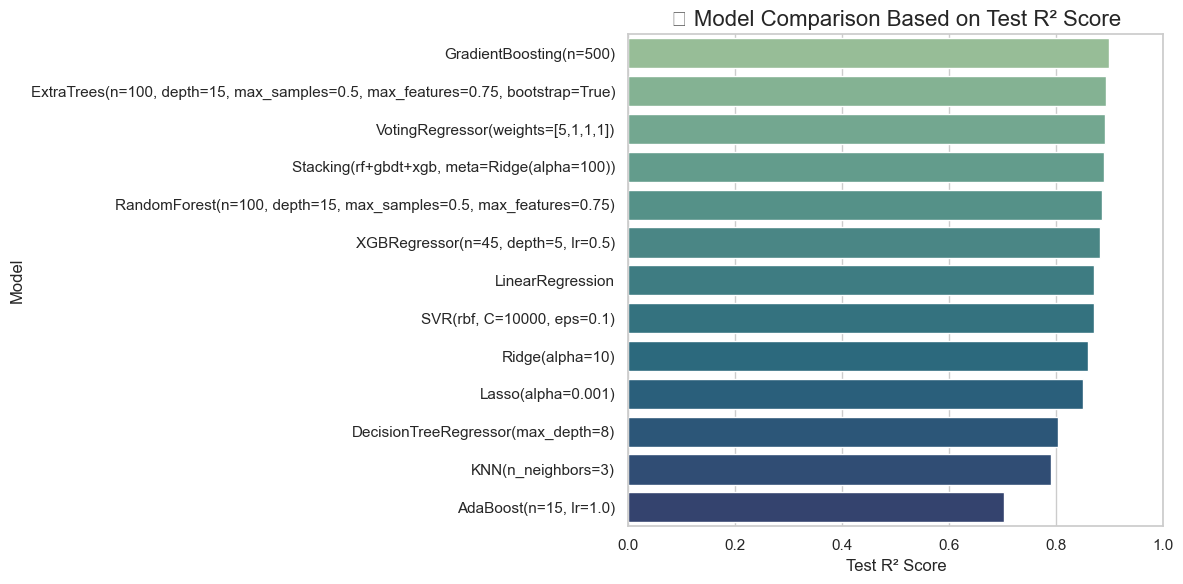

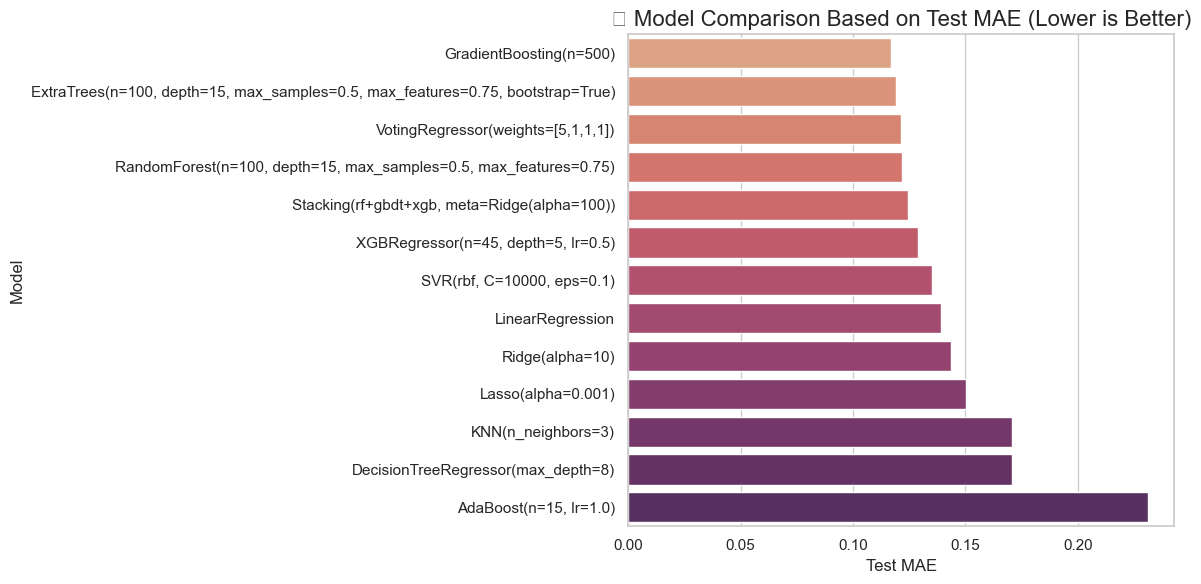

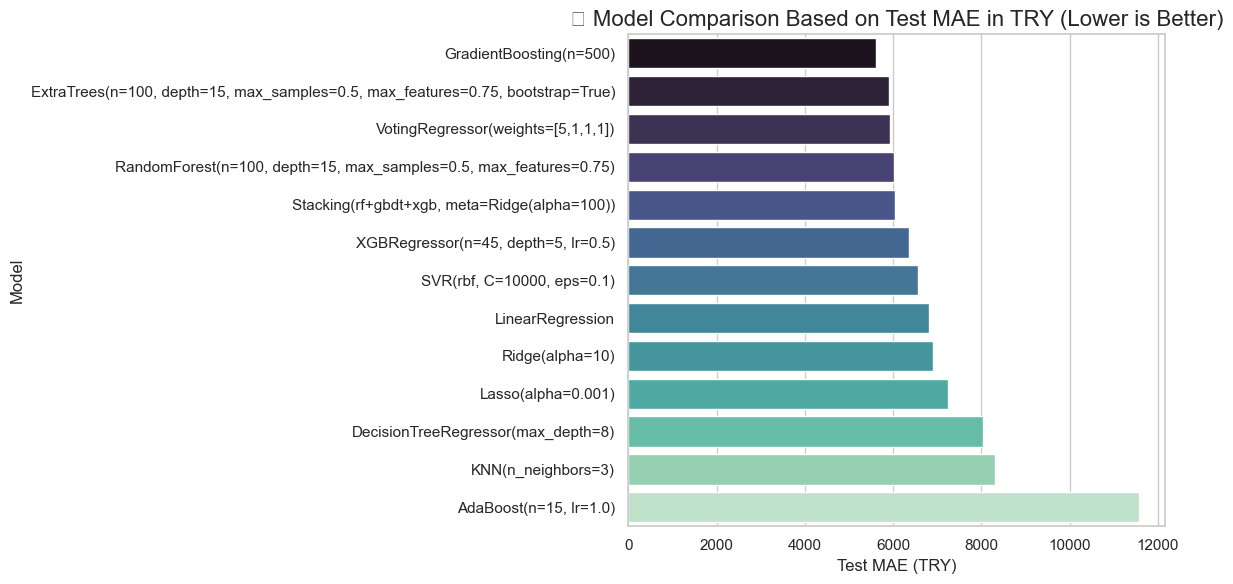

🔢 Tabular Results (sorted by Test R²):


,Model,R2_train,R2_test,MAE_train,MAE_test,MAE_TRY_train,MAE_TRY_test,CV_R2_train_mean,target_is_log
9,GradientBoosting(n=500),0.944017,0.898003,0.093571,0.117043,4521.238325,5624.043900,0.866700,True
7,"ExtraTrees(n=100, depth=15, max_samples=0.5, m...",0.941720,0.892985,0.089221,0.119176,4700.986231,5898.518643,0.868156,True
11,"VotingRegressor(weights=[5,1,1,1])",0.935271,0.891038,0.096858,0.121275,4915.474180,5922.100500,0.865520,True
12,"Stacking(rf+gbdt+xgb, meta=Ridge(alpha=100))",0.928367,0.888572,0.105260,0.124532,5286.559953,6053.608991,0.863834,True
6,"RandomForest(n=100, depth=15, max_samples=0.5,...",0.941317,0.885936,0.089004,0.121716,4612.176651,6025.040550,0.860985,True
10,"XGBRegressor(n=45, depth=5, lr=0.5)",0.948650,0.881619,0.090534,0.128935,4442.278662,6354.769537,0.858756,True
0,LinearRegression,0.876495,0.869549,0.136261,0.138973,7314.205561,6816.642731,0.802035,True
5,"SVR(rbf, C=10000, eps=0.1)",0.864554,0.869430,0.133306,0.135209,6625.928146,6557.028791,0.841303,True
1,Ridge(alpha=10),0.850675,0.859826,0.149078,0.143672,7950.415652,6911.401096,0.829423,True
2,Lasso(alpha=0.001),0.835343,0.849392,0.156259,0.150449,8493.177505,7255.754919,0.822121,True


In [36]:
# Convert results
results_df = pd.DataFrame(model_results)

# Style
sns.set(style="whitegrid")

# --- Plot Test R² (desc) ---
plt.figure(figsize=(12, 6))
sns.barplot(
    x="R2_test",
    y="Model",
    data=results_df.sort_values(by="R2_test", ascending=False),
    palette="crest",
)
plt.title("🔎 Model Comparison Based on Test R² Score", fontsize=16)
plt.xlabel("Test R² Score")
plt.ylabel("Model")
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

# --- Plot Test MAE (asc) ---
plt.figure(figsize=(12, 6))
sns.barplot(
    x="MAE_test",
    y="Model",
    data=results_df.sort_values(by="MAE_test", ascending=True),
    palette="flare",
)
plt.title("📉 Model Comparison Based on Test MAE (Lower is Better)", fontsize=16)
plt.xlabel("Test MAE")
plt.ylabel("Model")
plt.tight_layout()
plt.show()

# --- Plot Test MAE (TRY) (asc) ---
plt.figure(figsize=(12, 6))
sns.barplot(
    x="MAE_TRY_test",
    y="Model",
    data=results_df.sort_values(by="MAE_TRY_test", ascending=True),
    palette="mako",
)
plt.title("💸 Model Comparison Based on Test MAE in TRY (Lower is Better)", fontsize=16)
plt.xlabel("Test MAE (TRY)")
plt.ylabel("Model")
plt.tight_layout()
plt.show()

print("🔢 Tabular Results (sorted by Test R²):")
display(results_df.sort_values(by="R2_test", ascending=False))